# Master MVA- Generative Modeling
### Assignment 25th Feb
### Benjamin Deporte

### Import librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Set Up

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.set_default_dtype(torch.float64)

if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(f"Using {device}")

!nvidia-smi

# set seeds for reproductibility
random_seed = 42
rng = np.random.default_rng(seed=random_seed)
torch.manual_seed(random_seed)

Using cuda
Sun Feb 16 22:10:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080        Off |   00000000:01:00.0 Off |                  N/A |
|  0%   45C    P8             18W /  370W |      26MiB /  10240MiB |      0%      Default |
|                                         |                        |                  N/A |
+------------------------------------

# 2D-Data

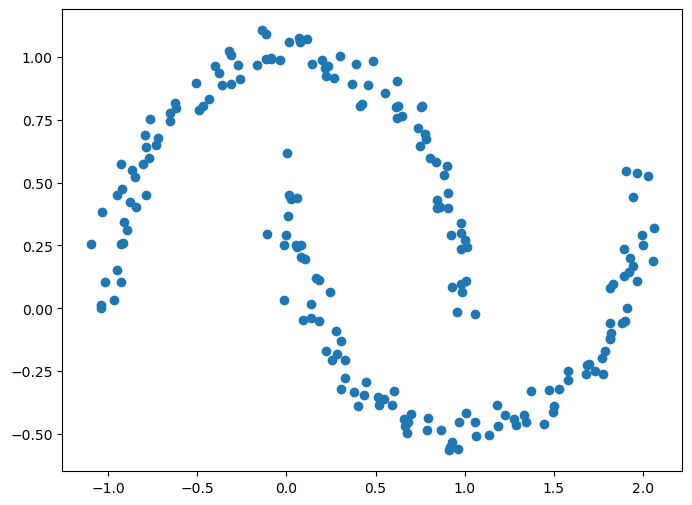

In [4]:
# Soyons fous... nous utiliserons 2-moons ici

from sklearn.datasets import make_moons

# paramètres
N_SAMPLES = 200
NOISE = 0.05

# génération données
X, _ = make_moons(n_samples=N_SAMPLES, noise=NOISE, random_state=random_seed)

# force dans [0,1]^2
# X[:,0] = (X[:,0] - np.min(X[:,0])) / (np.max(X[:,0]) - np.min(X[:,0]))
# X[:,1] = (X[:,1] - np.min(X[:,1])) / (np.max(X[:,1]) - np.min(X[:,1]))

# formate en tensor
X_data = torch.tensor(X).to(device)

# plot dataset
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X_data.detach().cpu().numpy()[:,0], X_data.detach().cpu().numpy()[:,1])

plt.show()

# GAN Training

In [5]:
# Generator - on ré-utilise le code du TP

class Generator(torch.nn.Module):

    def __init__(self, n_in, n_out, n_hid=10, nlayers=3, device=device):
        super(Generator, self).__init__()

        self.n_in = n_in
        self.n_out = n_out
        self.n_hid = n_hid
        self.nlayers = nlayers
        self.hidden = nn.ModuleList()

        # create nlayers of nn.Linear of size
        # - n_in for the first one
        # - n_hid for the others
        for n in range(nlayers):
            n_in_t = n_in if n==0 else n_hid
            self.hidden.append(nn.Sequential(
            nn.Linear(n_in_t, n_hid),
            nn.ELU(1)
        ).to(device))

        # otuput layer, n_out neurons then Sigmoid
        self.out = nn.Sequential(
            nn.Linear(n_hid, n_out),
            # nn.Sigmoid()
        ).to(device)

        self.apply(self._init_weights)


    def forward(self, x):
        for n in range(self.nlayers):
            x = self.hidden[n](x)
        x = self.out(x)
        return x


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight, 1.0)
            if module.bias is not None:
                module.bias.data.zero_()

In [6]:
n_in = 10    # input dimension, dimension de la Gaussienne dont est tiré z
d = 2        # dimension des data points

b = 100      # batch size

# Initialise générateur
G = Generator(n_in=n_in, n_out=d, n_hid=100, nlayers=3, device=device)

# Draw a batch x of generated points
#    Input noise z : standard normal with shape (b, n_in)
z = torch.randn(b, n_in, device=device)
X_gen = G(z).detach().cpu().numpy()

In [7]:
def display(x_data=X_data, x_gen=None):
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.scatter(x_gen[:,0], x_gen[:,1], c='deepskyblue')
    ax.scatter(x_data[:,0], x_data[:,1], c='navy')
    plt.show()

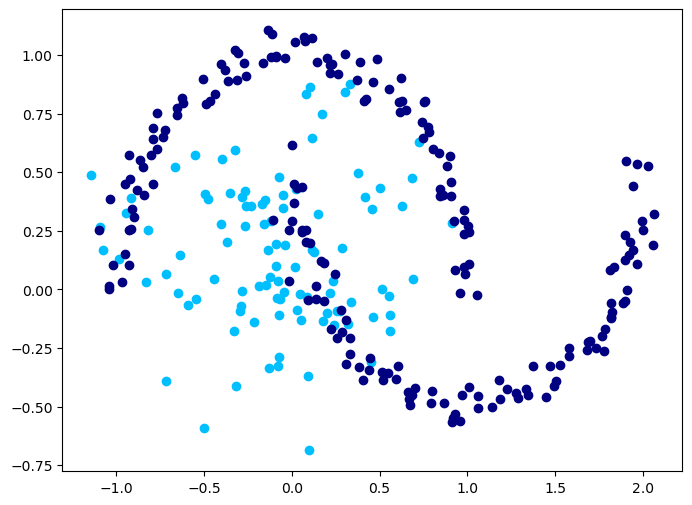

In [8]:
# Teste le sampling

display(X_data.cpu(), X_gen)

In [9]:
# Discriminator - code TP

class DiscriminatorGAN(nn.Module):
  def __init__(self, n_in=2, n_hid=10, device=device):
    super(DiscriminatorGAN, self).__init__()

    # n_in is the input dimension, 2 here as data points are 2D
    self.n_hid = n_hid
    self.n_in = n_in    

    self.fc1 = nn.Linear(n_in, n_hid).to(device)
    self.fc2 = nn.Linear(n_hid, n_hid).to(device)
    self.fc3 = nn.Linear(n_hid, 1).to(device)

  def forward(self, x):
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc1(x))
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc2(y))
    # proba que x soit issu de p_data et non pas p_gen = G(p_z)
    y = nn.Sigmoid()(self.fc3(y))
    return y

### GAN Training Loop

TP code Evolution :
- commented code regarding gradient clipping
- added kwarg "GenFreeze" to allow training of Discriminator only
- a couple of prints

In [10]:
def train_GAN(
  GenFreeze=False,
  niterD=100,
  niterG=1,
  n_epochs=50,
  lrdisc=1e-2,
  lrgen=1e-3,
  iter_display=10
  ):
  
  # Report out
  print(f"Training GAN - GenFreeze={GenFreeze}")
  # Training loop

  # parameters
  lrgen = lrgen   # learning rate for generator
  lrdisc = lrdisc  # learning rate for discriminator
  n_epochs = n_epochs
  niterD=niterD
  niterG=niterG

  # Initialize generator and discriminator
  G = Generator(n_in=n_in, n_out=d, n_hid=100, nlayers=3, device=device)
  D = DiscriminatorGAN(n_in=d, n_hid=100, device=device)

  # get ready
  optimG = optim.Adam(G.parameters(), lr=lrgen)
  optimD = optim.Adam(D.parameters(), lr=lrdisc) #, betas=(beta_1, beta_2))

  # logs
  Glosses = []
  Dlosses = []

  # reporting 
  iter_display = iter_display

  # Main loop
  for epoch in range(1,n_epochs):

      ###########################################
      ### Train discriminator (niterD iterations)
      ###########################################
      
      #### ie max sur D de la loss
      for iter in range(0,niterD):
        optimD.zero_grad()
        X_gen = G(torch.randn(b, n_in, device=device))
        Dx = D(X_gen)
        # we want to maximize D(X_data) and minimize D(X_gen)
        # Dloss should be as small as possible
        Dloss = - (torch.mean(D(X_data)) - torch.mean(Dx))
        optimD.zero_grad()
        Dloss.backward()
        optimD.step()
        # GAN : no gradient cliping !
        # for p in D.parameters():
        #     p.data.clamp_(-clip_value, clip_value)

      #######################################
      ### Train generator (niterG iterations)
      #######################################
      ### ie min sur G de la loss
      for iter in range(0,niterG):
        # we want to maximize D(G(z))
        # Gloss should be as small as possible
        Gloss = - torch.mean(D(G(torch.randn(b, n_in, device=device))))
        if GenFreeze is not True:
          optimG.zero_grad()
          Gloss.backward()
          optimG.step()

      # Output training stats
      print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
        % (epoch, n_epochs, Dloss.item(), Gloss.item()))
      Glosses.append(Gloss.item())
      Dlosses.append(Dloss.item())

      # draw pictures from time to time
      if(epoch % iter_display == 0):
          fig, ax = plt.subplots(figsize=(4, 4))
          # plot data
          ax.scatter(X_data.cpu()[:,0], X_data.cpu()[:,1], c='navy')
          # plot generated points
          z = torch.randn(b, n_in, device=device)
          x_gen = G(z).detach().cpu().numpy()
          ax.scatter(x_gen[:,0], x_gen[:,1], c='deepskyblue')
          plt.show()

  ### Plot the evolution of the discriminator and generator losses ###
  plt.figure(dpi=100)
  plt.plot(Dlosses,label='D')
  plt.plot(Glosses,label='G')
  plt.title(f'Loss evolution - GenFreeze={GenFreeze}')
  plt.legend()
  plt.show()

### Training D, fixed G

Ok, we succeed in training D (sort of : -.80 loss vs -1.00 optimal) when G is frozen.

Training GAN - GenFreeze=True
[1/200] 	Loss_D: -0.5877	Loss_G: -0.0551
[2/200] 	Loss_D: -0.6245	Loss_G: -0.0383
[3/200] 	Loss_D: -0.6301	Loss_G: -0.0393
[4/200] 	Loss_D: -0.6384	Loss_G: -0.0619
[5/200] 	Loss_D: -0.6557	Loss_G: -0.1021
[6/200] 	Loss_D: -0.6929	Loss_G: -0.0544
[7/200] 	Loss_D: -0.7371	Loss_G: -0.0401
[8/200] 	Loss_D: -0.7734	Loss_G: -0.0869
[9/200] 	Loss_D: -0.7126	Loss_G: -0.0490
[10/200] 	Loss_D: -0.7335	Loss_G: -0.1019
[11/200] 	Loss_D: -0.7804	Loss_G: -0.0661
[12/200] 	Loss_D: -0.7583	Loss_G: -0.0303
[13/200] 	Loss_D: -0.7635	Loss_G: -0.0488
[14/200] 	Loss_D: -0.7792	Loss_G: -0.0539
[15/200] 	Loss_D: -0.7995	Loss_G: -0.0779
[16/200] 	Loss_D: -0.7265	Loss_G: -0.0871
[17/200] 	Loss_D: -0.7669	Loss_G: -0.0611
[18/200] 	Loss_D: -0.7766	Loss_G: -0.0796
[19/200] 	Loss_D: -0.7629	Loss_G: -0.0760
[20/200] 	Loss_D: -0.7809	Loss_G: -0.0311
[21/200] 	Loss_D: -0.7689	Loss_G: -0.0804
[22/200] 	Loss_D: -0.7900	Loss_G: -0.0397
[23/200] 	Loss_D: -0.7919	Loss_G: -0.0918
[24/200] 	Los

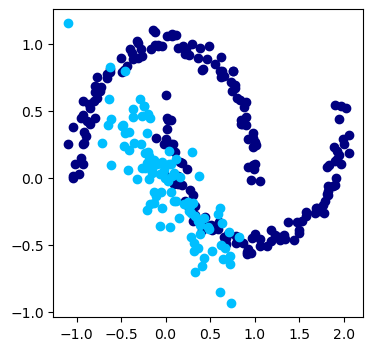

[51/200] 	Loss_D: -0.8108	Loss_G: -0.0535
[52/200] 	Loss_D: -0.8140	Loss_G: -0.0300
[53/200] 	Loss_D: -0.7792	Loss_G: -0.0300
[54/200] 	Loss_D: -0.7338	Loss_G: -0.0457
[55/200] 	Loss_D: -0.7954	Loss_G: -0.0276
[56/200] 	Loss_D: -0.7742	Loss_G: -0.0782
[57/200] 	Loss_D: -0.7867	Loss_G: -0.0205
[58/200] 	Loss_D: -0.8379	Loss_G: -0.0599
[59/200] 	Loss_D: -0.7814	Loss_G: -0.0597
[60/200] 	Loss_D: -0.7622	Loss_G: -0.0532
[61/200] 	Loss_D: -0.7884	Loss_G: -0.0390
[62/200] 	Loss_D: -0.7807	Loss_G: -0.0320
[63/200] 	Loss_D: -0.8091	Loss_G: -0.0513
[64/200] 	Loss_D: -0.8072	Loss_G: -0.0272
[65/200] 	Loss_D: -0.7819	Loss_G: -0.0359
[66/200] 	Loss_D: -0.7762	Loss_G: -0.0831
[67/200] 	Loss_D: -0.7936	Loss_G: -0.0883
[68/200] 	Loss_D: -0.8063	Loss_G: -0.0156
[69/200] 	Loss_D: -0.8058	Loss_G: -0.0899
[70/200] 	Loss_D: -0.7817	Loss_G: -0.0409
[71/200] 	Loss_D: -0.7879	Loss_G: -0.0355
[72/200] 	Loss_D: -0.7707	Loss_G: -0.0822
[73/200] 	Loss_D: -0.8005	Loss_G: -0.0780
[74/200] 	Loss_D: -0.8283	Loss_G: 

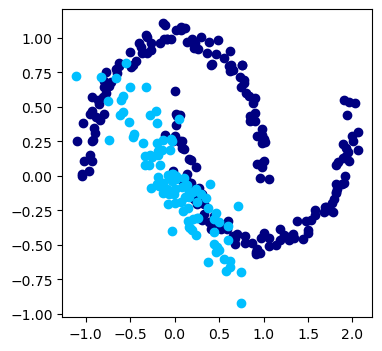

[101/200] 	Loss_D: -0.8035	Loss_G: -0.0385
[102/200] 	Loss_D: -0.8023	Loss_G: -0.0518
[103/200] 	Loss_D: -0.8096	Loss_G: -0.0867
[104/200] 	Loss_D: -0.8292	Loss_G: -0.0397
[105/200] 	Loss_D: -0.8058	Loss_G: -0.0493
[106/200] 	Loss_D: -0.8137	Loss_G: -0.0400
[107/200] 	Loss_D: -0.8238	Loss_G: -0.0702
[108/200] 	Loss_D: -0.7559	Loss_G: -0.0461
[109/200] 	Loss_D: -0.7668	Loss_G: -0.0934
[110/200] 	Loss_D: -0.8048	Loss_G: -0.0468
[111/200] 	Loss_D: -0.7787	Loss_G: -0.0665
[112/200] 	Loss_D: -0.7813	Loss_G: -0.0295
[113/200] 	Loss_D: -0.8194	Loss_G: -0.0600
[114/200] 	Loss_D: -0.7852	Loss_G: -0.0602
[115/200] 	Loss_D: -0.7878	Loss_G: -0.0501
[116/200] 	Loss_D: -0.7568	Loss_G: -0.0200
[117/200] 	Loss_D: -0.7896	Loss_G: -0.0743
[118/200] 	Loss_D: -0.7995	Loss_G: -0.0692
[119/200] 	Loss_D: -0.7833	Loss_G: -0.0399
[120/200] 	Loss_D: -0.7804	Loss_G: -0.0636
[121/200] 	Loss_D: -0.7874	Loss_G: -0.0200
[122/200] 	Loss_D: -0.7994	Loss_G: -0.0605
[123/200] 	Loss_D: -0.7305	Loss_G: -0.0000
[124/200] 	

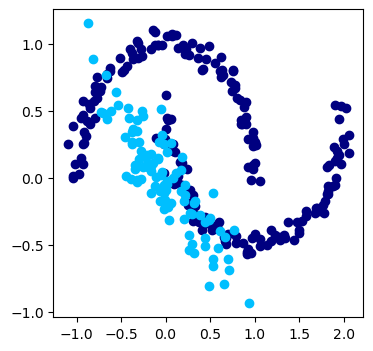

[151/200] 	Loss_D: -0.7782	Loss_G: -0.0365
[152/200] 	Loss_D: -0.7594	Loss_G: -0.0200
[153/200] 	Loss_D: -0.8102	Loss_G: -0.0477
[154/200] 	Loss_D: -0.7903	Loss_G: -0.0900
[155/200] 	Loss_D: -0.7994	Loss_G: -0.0301
[156/200] 	Loss_D: -0.7602	Loss_G: -0.0474
[157/200] 	Loss_D: -0.7573	Loss_G: -0.0401
[158/200] 	Loss_D: -0.8162	Loss_G: -0.0400
[159/200] 	Loss_D: -0.8087	Loss_G: -0.0494
[160/200] 	Loss_D: -0.8399	Loss_G: -0.0904
[161/200] 	Loss_D: -0.7775	Loss_G: -0.0348
[162/200] 	Loss_D: -0.7996	Loss_G: -0.0209
[163/200] 	Loss_D: -0.8170	Loss_G: -0.0198
[164/200] 	Loss_D: -0.7795	Loss_G: -0.0800
[165/200] 	Loss_D: -0.8144	Loss_G: -0.0300
[166/200] 	Loss_D: -0.7751	Loss_G: -0.0755
[167/200] 	Loss_D: -0.7898	Loss_G: -0.0827
[168/200] 	Loss_D: -0.8196	Loss_G: -0.0400
[169/200] 	Loss_D: -0.7688	Loss_G: -0.0520
[170/200] 	Loss_D: -0.7971	Loss_G: -0.0303
[171/200] 	Loss_D: -0.8130	Loss_G: -0.0692
[172/200] 	Loss_D: -0.7738	Loss_G: -0.0179
[173/200] 	Loss_D: -0.7996	Loss_G: -0.0481
[174/200] 	

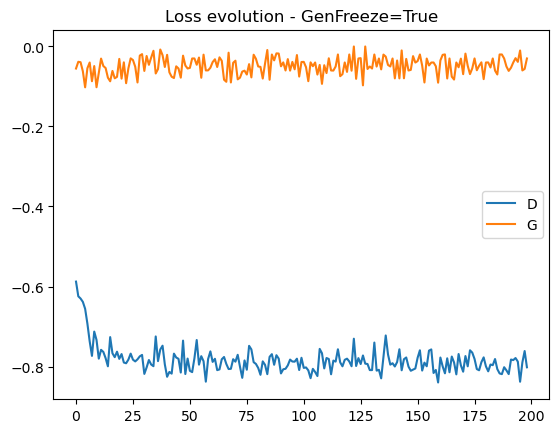

In [11]:
train_GAN(GenFreeze=True, lrdisc=1e-3, n_epochs=200, iter_display=50)

### Full training of D and G

We put 500 training iterations on D for 1 (one !) on G.
Still, training fails.

Training GAN - GenFreeze=False
[1/100] 	Loss_D: -0.5832	Loss_G: -0.1333
[2/100] 	Loss_D: -0.5971	Loss_G: -0.1419
[3/100] 	Loss_D: -0.5716	Loss_G: -0.2279
[4/100] 	Loss_D: -0.4649	Loss_G: -0.3008
[5/100] 	Loss_D: -0.3131	Loss_G: -0.4581
[6/100] 	Loss_D: -0.2132	Loss_G: -0.5112
[7/100] 	Loss_D: -0.2299	Loss_G: -0.4994
[8/100] 	Loss_D: -0.1708	Loss_G: -0.5342
[9/100] 	Loss_D: -0.1903	Loss_G: -0.6754
[10/100] 	Loss_D: -0.2805	Loss_G: -0.7721
[11/100] 	Loss_D: -0.1942	Loss_G: -0.6768
[12/100] 	Loss_D: -0.2499	Loss_G: -0.6570
[13/100] 	Loss_D: -0.3881	Loss_G: -0.6116
[14/100] 	Loss_D: -0.4489	Loss_G: -0.5524
[15/100] 	Loss_D: -0.6732	Loss_G: -0.2261
[16/100] 	Loss_D: -0.7567	Loss_G: -0.2412
[17/100] 	Loss_D: -0.7860	Loss_G: -0.1700
[18/100] 	Loss_D: -0.7448	Loss_G: -0.2515
[19/100] 	Loss_D: -0.7300	Loss_G: -0.2649
[20/100] 	Loss_D: -0.8002	Loss_G: -0.2829
[21/100] 	Loss_D: -0.7869	Loss_G: -0.2144
[22/100] 	Loss_D: -0.7133	Loss_G: -0.2081
[23/100] 	Loss_D: -0.7790	Loss_G: -0.2425
[24/100] 	Lo

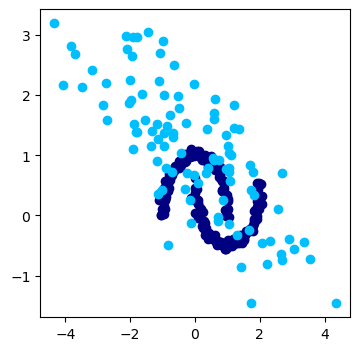

[26/100] 	Loss_D: -0.8040	Loss_G: -0.2676
[27/100] 	Loss_D: -0.6501	Loss_G: -0.2258
[28/100] 	Loss_D: -0.7125	Loss_G: -0.2654
[29/100] 	Loss_D: -0.7035	Loss_G: -0.2663
[30/100] 	Loss_D: -0.6913	Loss_G: -0.3602
[31/100] 	Loss_D: -0.6030	Loss_G: -0.3184
[32/100] 	Loss_D: -0.6760	Loss_G: -0.3178
[33/100] 	Loss_D: -0.6130	Loss_G: -0.3672
[34/100] 	Loss_D: -0.6507	Loss_G: -0.3595
[35/100] 	Loss_D: -0.6634	Loss_G: -0.4046
[36/100] 	Loss_D: -0.5909	Loss_G: -0.4119
[37/100] 	Loss_D: -0.4756	Loss_G: -0.4350
[38/100] 	Loss_D: -0.5837	Loss_G: -0.4521
[39/100] 	Loss_D: -0.5639	Loss_G: -0.5168
[40/100] 	Loss_D: -0.5922	Loss_G: -0.4419
[41/100] 	Loss_D: -0.4869	Loss_G: -0.4678
[42/100] 	Loss_D: -0.4680	Loss_G: -0.5042
[43/100] 	Loss_D: -0.5368	Loss_G: -0.4585
[44/100] 	Loss_D: -0.4796	Loss_G: -0.4787
[45/100] 	Loss_D: -0.4668	Loss_G: -0.5594
[46/100] 	Loss_D: -0.4382	Loss_G: -0.6233
[47/100] 	Loss_D: -0.3653	Loss_G: -0.6412
[48/100] 	Loss_D: -0.3434	Loss_G: -0.6319
[49/100] 	Loss_D: -0.3241	Loss_G: 

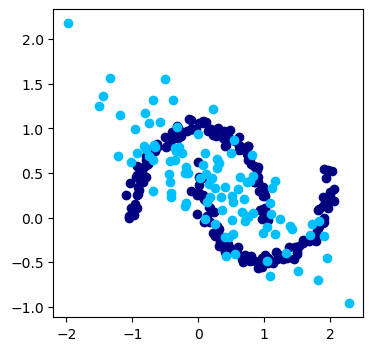

[51/100] 	Loss_D: -0.2477	Loss_G: -0.7159
[52/100] 	Loss_D: -0.2387	Loss_G: -0.8171
[53/100] 	Loss_D: -0.1138	Loss_G: -0.8305
[54/100] 	Loss_D: -0.1085	Loss_G: -0.8884
[55/100] 	Loss_D: -0.0714	Loss_G: -0.9296
[56/100] 	Loss_D: -0.0923	Loss_G: -0.9600
[57/100] 	Loss_D: -0.0436	Loss_G: -0.9475
[58/100] 	Loss_D: -0.0301	Loss_G: -0.9737
[59/100] 	Loss_D: -0.0089	Loss_G: -0.9798
[60/100] 	Loss_D: 0.0022	Loss_G: -0.9878
[61/100] 	Loss_D: 0.0002	Loss_G: -1.0000
[62/100] 	Loss_D: 0.0005	Loss_G: -1.0000
[63/100] 	Loss_D: 0.0007	Loss_G: -0.9900
[64/100] 	Loss_D: 0.0001	Loss_G: -1.0000
[65/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[66/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[67/100] 	Loss_D: 0.0003	Loss_G: -1.0000
[68/100] 	Loss_D: 0.0004	Loss_G: -0.9900
[69/100] 	Loss_D: 0.0006	Loss_G: -0.9997
[70/100] 	Loss_D: -0.0390	Loss_G: -0.9900
[71/100] 	Loss_D: -0.0223	Loss_G: -1.0000
[72/100] 	Loss_D: 0.0002	Loss_G: -0.9900
[73/100] 	Loss_D: -0.0668	Loss_G: -0.9701
[74/100] 	Loss_D: -0.7418	Loss_G: -0.0541
[75

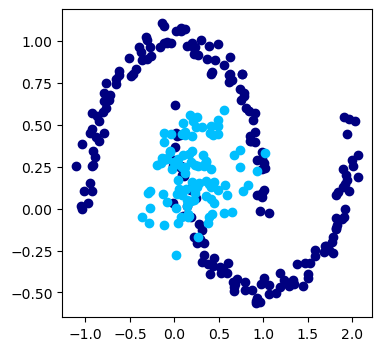

[76/100] 	Loss_D: -0.7681	Loss_G: -0.0494
[77/100] 	Loss_D: -0.7372	Loss_G: -0.0492
[78/100] 	Loss_D: -0.7634	Loss_G: -0.0417
[79/100] 	Loss_D: -0.7310	Loss_G: -0.0600
[80/100] 	Loss_D: -0.7155	Loss_G: -0.1160
[81/100] 	Loss_D: -0.6589	Loss_G: -0.1647
[82/100] 	Loss_D: -0.5609	Loss_G: -0.1669
[83/100] 	Loss_D: -0.5379	Loss_G: -0.2457
[84/100] 	Loss_D: -0.4997	Loss_G: -0.2190
[85/100] 	Loss_D: -0.4526	Loss_G: -0.4400
[86/100] 	Loss_D: -0.4246	Loss_G: -0.4134
[87/100] 	Loss_D: -0.2725	Loss_G: -0.4295
[88/100] 	Loss_D: -0.3726	Loss_G: -0.5926
[89/100] 	Loss_D: -0.2944	Loss_G: -0.5153
[90/100] 	Loss_D: -0.2438	Loss_G: -0.5993
[91/100] 	Loss_D: -0.1195	Loss_G: -0.6437
[92/100] 	Loss_D: -0.1789	Loss_G: -0.6767
[93/100] 	Loss_D: -0.1895	Loss_G: -0.6122
[94/100] 	Loss_D: -0.6305	Loss_G: -0.2435
[95/100] 	Loss_D: -0.6466	Loss_G: -0.1431
[96/100] 	Loss_D: -0.7282	Loss_G: -0.1500
[97/100] 	Loss_D: -0.7300	Loss_G: -0.1362
[98/100] 	Loss_D: -0.6995	Loss_G: -0.1729
[99/100] 	Loss_D: -0.6796	Loss_G: 

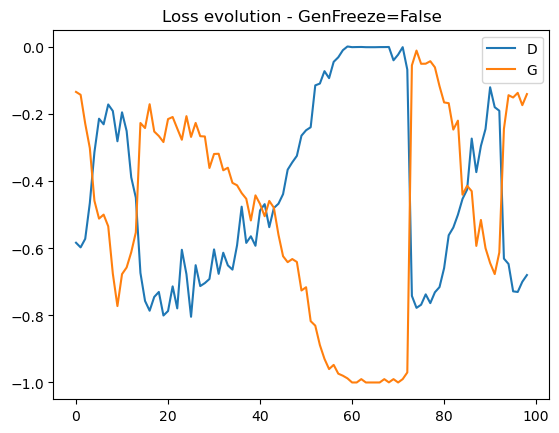

In [12]:
train_GAN(GenFreeze=False, niterD=100, lrdisc=1e-3, n_epochs=100, iter_display=25)

### Q1.a Comment on the differences with respect to the WGAN learning algorithm.

The vanilla loss of GANs leads to try to optimise a JS divergence (in fact, two KL-divergences), between $p_{data}$ the probability distribution of the data in $\mathbb{R}^2$, and $p_{gen}(G(z))$ the probability distribution of $G(z)$ where $G$ is the generator and $z$ is drawn from a Gaussian. Issues arise when the supports of $p_{data}$ and  $p_{gen}(G(z))$ are disjoint, or worse, separated. Then the KLs go to infinity and the gradients vanish, making training unstable.

The WGAN loss is a Wasserstein loss, more precisely uses the dual formulation of the Wasserstein distance, based on Lipschitz functions. The Wasserstein distance has better conitnuity and differentiability properties than KL (euphemism) making training, theoretically, easier. However, the training algorithm needs to contain the gradient of the functions to keep them Lipschitz (ie by clipping or by regularization with gradient-penalty).

### Q1.b. Comment on the possible stability problems that you may encounter with the GAN algorithm.

As said above, the issue arises when the supports of $p_{data}$ and $p_{gen}(G(z))$ are disjoint, or worse, separated. The gradients vanish, we can get to a mode collapse, etc.

# WGAN Training

Evolution of the code

- added kwargs clip (Boolean) and grad_penalty (Boolean) to choose Lipschitz enforcement
- coded (and added printing) D gradient norm estimation

In [13]:
def train_WGAN(
  GenFreeze=False,
  niterD=100,
  niterG=1,
  lrdisc=1e-2,
  lrgen=1e-3,
  iter_display=10,
  n_epochs=50,
  lambd = 1.0, # regul coeff for gradient penalty
  clip_value = 0.05,
  clip=False,
  grad_penalty=False
  ):
  """WGAN Training - same as GAN, but added regularization
  """
  
  # Report out
  print(f"Training WGAN - GenFreeze={GenFreeze}")
  
  if clip is False and grad_penalty is False:
    print(f"No regularization")
  elif clip is True:
    print(f"Clipping gradient with clip_value = {clip_value}")
  else:
    print(f"Gradient penalty with lambda = {lambd}")
  
  # Training loop

  # parameters
  lrgen = lrgen   # learning rate for generator
  lrdisc = lrdisc  # learning rate for discriminator
  n_epochs = n_epochs
  niterD=niterD
  niterG=niterG
  lambd=lambd
  clip_value=clip_value

  # Initialize generator and discriminator
  G = Generator(n_in=n_in, n_out=d, n_hid=100, nlayers=3, device=device)
  D = DiscriminatorGAN(n_in=d, n_hid=100, device=device)

  # get ready
  optimG = optim.Adam(G.parameters(), lr=lrgen)
  optimD = optim.Adam(D.parameters(), lr=lrdisc) #, betas=(beta_1, beta_2))

  # logs
  Glosses = []
  Dlosses = []
  Gradient_norms = []

  # reporting 
  iter_display = iter_display
  
  # misc
  n_data = X_data.shape[0]

  # Main loop
  for epoch in range(1,n_epochs):

      ###########################################
      ### Train discriminator (niterD iterations)
      ###########################################
      
      #### ie max sur D de la loss
      for iter in range(0,niterD):
        g_norm_ests = []
        optimD.zero_grad()
        X_gen = G(torch.randn(b, n_in, device=device))
        Dx = D(X_gen)
        # we want to maximize D(X_data) and minimize D(X_gen)
        # Dloss should be as small as possible
        Dloss = - (torch.mean(D(X_data)) - torch.mean(Dx))
        
        if grad_penalty is True and clip is False:
          # Estimate Gradient of Discriminator
          
          # Sample points from the generator
          z = torch.randn(n_data, n_in, device=device)
          x = G(z) # shape : N x 2
          # Calculate interpolation between data and generated points
          alpha = torch.rand((n_data,1),device=device) # N x 1
          interp = (alpha * n_data + (1-alpha) * x) # .flatten(end_dim=1) # N x 2
          interp.requires_grad_()
          
          D_interp = D(interp) # N x 1
          gradout = torch.ones(D_interp.size()).to(device) # N x 1
          # autograd will actually compute a Gradient tensor N x 2, as output is N x scalar and input is N x 2
          gradients = torch.autograd.grad(outputs = D_interp, inputs = interp, grad_outputs = gradout, create_graph = True, retain_graph = True)[0] # N x 2
          
          est_gradient_norm = torch.mean(torch.sqrt((torch.sum(gradients**2,dim=1)))) # N x 1
          
          # print(f"Gradient norm estimate : {est_gradient_norm}")
          
          g_norm_ests.append(est_gradient_norm.item())
          # # calculate the loss with gradient penalty
          Dloss += lambd * (est_gradient_norm - 1)**2
        
        # clipping gradients if required
        if clip is True and grad_penalty is False:
          for p in D.parameters():
            p.data.clamp_(-clip_value, clip_value)
            
        # optimize
        optimD.zero_grad()
        Dloss.backward()
        optimD.step()

      if grad_penalty is True and clip is False:
        Gradient_norms.append(np.average(g_norm_ests))

      #######################################
      ### Train generator (niterG iterations)
      #######################################
      ### ie min sur G de la loss
      for iter in range(0,niterG):
        # we want to maximize D(G(z))
        # Gloss should be as small as possible
        Gloss = - torch.mean(D(G(torch.randn(b, n_in, device=device))))
        if GenFreeze is not True:
          optimG.zero_grad()
          Gloss.backward()
          optimG.step()

      # Output training stats
      if grad_penalty is False:
        print('[%d/%d] \tLoss_D: %.4f \tLoss_G: %.4f'
          % (epoch, n_epochs, Dloss.item(), Gloss.item()))
      else:
        print('[%d/%d] \tLoss_D: %.4f \tLoss_G: %.4f \tGradient_norm_est: %.4f'
          % (epoch, n_epochs, Dloss.item(), Gloss.item(), np.average(g_norm_ests)))
      Glosses.append(Gloss.item())
      Dlosses.append(Dloss.item())

      # draw pictures from time to time
      if(epoch % iter_display == 0):
          fig, ax = plt.subplots(figsize=(4, 4))
          # plot data
          ax.scatter(X_data.cpu()[:,0], X_data.cpu()[:,1], c='navy')
          # plot generated points
          z = torch.randn(b, n_in, device=device)
          x_gen = G(z).detach().cpu().numpy()
          ax.scatter(x_gen[:,0], x_gen[:,1], c='deepskyblue')
          plt.show()

  ### Plot the evolution of the discriminator and generator losses ###
  plt.figure(dpi=100)
  plt.plot(Dlosses,label='D')
  plt.plot(Glosses,label='G')
  # plt.plot(Gradient_norms, label='Gradient Norm Discriminator')
  plt.title(f'Loss evolution - GenFreeze={GenFreeze}')
  plt.legend()
  plt.show()

### WGAN-WC

Testing weight clipping

Training WGAN - GenFreeze=True
Clipping gradient with clip_value = 10.0
[1/50] 	Loss_D: -0.3928 	Loss_G: -0.5159
[2/50] 	Loss_D: -0.4439 	Loss_G: -0.4638
[3/50] 	Loss_D: -0.3488 	Loss_G: -0.4399
[4/50] 	Loss_D: -0.6026 	Loss_G: -0.5139
[5/50] 	Loss_D: -0.5309 	Loss_G: -0.4750
[6/50] 	Loss_D: -0.4983 	Loss_G: -0.4383
[7/50] 	Loss_D: -0.5602 	Loss_G: -0.4998
[8/50] 	Loss_D: -0.5144 	Loss_G: -0.4505
[9/50] 	Loss_D: -0.5006 	Loss_G: -0.4630
[10/50] 	Loss_D: -0.5437 	Loss_G: -0.4569


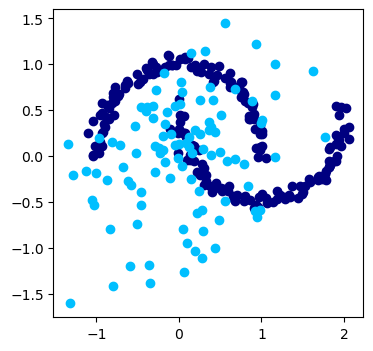

[11/50] 	Loss_D: -0.5760 	Loss_G: -0.5338
[12/50] 	Loss_D: -0.5949 	Loss_G: -0.5130
[13/50] 	Loss_D: -0.5423 	Loss_G: -0.4914
[14/50] 	Loss_D: -0.6226 	Loss_G: -0.4672
[15/50] 	Loss_D: -0.5745 	Loss_G: -0.3524
[16/50] 	Loss_D: -0.4406 	Loss_G: -0.4131
[17/50] 	Loss_D: -0.5749 	Loss_G: -0.4340
[18/50] 	Loss_D: -0.4882 	Loss_G: -0.4444
[19/50] 	Loss_D: -0.5390 	Loss_G: -0.5060
[20/50] 	Loss_D: -0.5368 	Loss_G: -0.4986


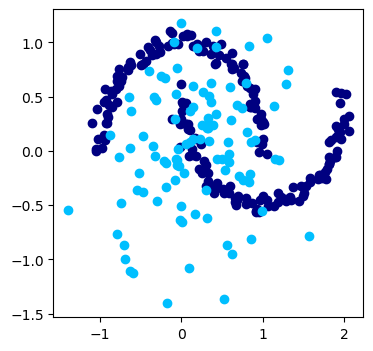

[21/50] 	Loss_D: -0.5946 	Loss_G: -0.4472
[22/50] 	Loss_D: -0.6356 	Loss_G: -0.4663
[23/50] 	Loss_D: -0.5655 	Loss_G: -0.4504
[24/50] 	Loss_D: -0.5610 	Loss_G: -0.3963
[25/50] 	Loss_D: -0.4705 	Loss_G: -0.4108
[26/50] 	Loss_D: -0.6395 	Loss_G: -0.4225
[27/50] 	Loss_D: -0.5270 	Loss_G: -0.4462
[28/50] 	Loss_D: -0.5640 	Loss_G: -0.5044
[29/50] 	Loss_D: -0.5536 	Loss_G: -0.4855
[30/50] 	Loss_D: -0.5226 	Loss_G: -0.4559


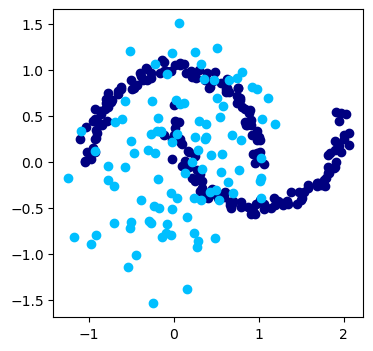

[31/50] 	Loss_D: -0.6026 	Loss_G: -0.3824
[32/50] 	Loss_D: -0.5614 	Loss_G: -0.4155
[33/50] 	Loss_D: -0.5865 	Loss_G: -0.4722
[34/50] 	Loss_D: -0.5972 	Loss_G: -0.4007
[35/50] 	Loss_D: -0.4139 	Loss_G: -0.4739
[36/50] 	Loss_D: -0.5672 	Loss_G: -0.4439
[37/50] 	Loss_D: -0.5706 	Loss_G: -0.4622
[38/50] 	Loss_D: -0.5563 	Loss_G: -0.4600
[39/50] 	Loss_D: -0.4795 	Loss_G: -0.3682
[40/50] 	Loss_D: -0.5503 	Loss_G: -0.4610


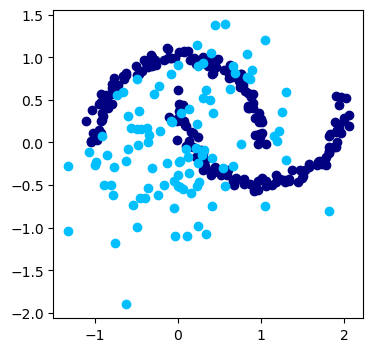

[41/50] 	Loss_D: -0.5283 	Loss_G: -0.4100
[42/50] 	Loss_D: -0.5493 	Loss_G: -0.5018
[43/50] 	Loss_D: -0.5304 	Loss_G: -0.4164
[44/50] 	Loss_D: -0.5867 	Loss_G: -0.4116
[45/50] 	Loss_D: -0.4970 	Loss_G: -0.4423
[46/50] 	Loss_D: -0.5510 	Loss_G: -0.3502
[47/50] 	Loss_D: -0.5705 	Loss_G: -0.4696
[48/50] 	Loss_D: -0.4721 	Loss_G: -0.4219
[49/50] 	Loss_D: -0.5322 	Loss_G: -0.4675


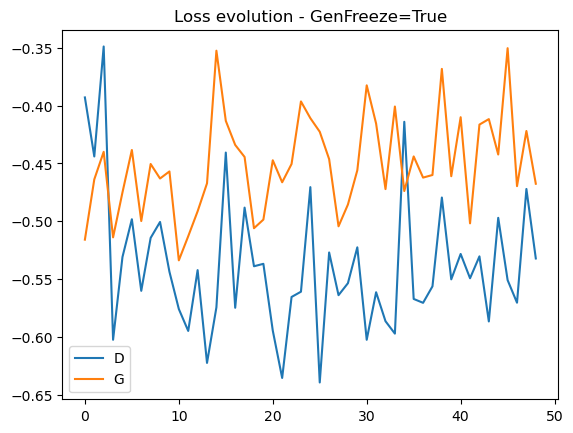

In [14]:
# First, training Discriminator with Generator frozen

train_WGAN(GenFreeze=True, lrdisc=1e-3, niterD=100, clip=True, clip_value=10.0, iter_display=10)

Training WGAN - GenFreeze=False
Clipping gradient with clip_value = 0.5
[1/100] 	Loss_D: -0.4236 	Loss_G: -0.2881
[2/100] 	Loss_D: -0.4754 	Loss_G: -0.4218
[3/100] 	Loss_D: -0.3678 	Loss_G: -0.5171
[4/100] 	Loss_D: -0.3369 	Loss_G: -0.5313
[5/100] 	Loss_D: -0.2715 	Loss_G: -0.6778
[6/100] 	Loss_D: -0.2383 	Loss_G: -0.7295
[7/100] 	Loss_D: -0.3042 	Loss_G: -0.6306
[8/100] 	Loss_D: -0.1715 	Loss_G: -0.7699
[9/100] 	Loss_D: -0.2235 	Loss_G: -0.8104
[10/100] 	Loss_D: -0.1196 	Loss_G: -0.8031


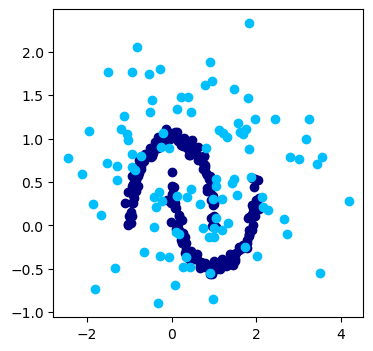

[11/100] 	Loss_D: -0.1202 	Loss_G: -0.8390
[12/100] 	Loss_D: -0.0618 	Loss_G: -0.9209
[13/100] 	Loss_D: -0.1697 	Loss_G: -0.6893
[14/100] 	Loss_D: -0.2044 	Loss_G: -0.6718
[15/100] 	Loss_D: -0.1860 	Loss_G: -0.6774
[16/100] 	Loss_D: -0.1414 	Loss_G: -0.6603
[17/100] 	Loss_D: -0.1114 	Loss_G: -0.7714
[18/100] 	Loss_D: -0.2352 	Loss_G: -0.6125
[19/100] 	Loss_D: -0.0465 	Loss_G: -0.7251
[20/100] 	Loss_D: -0.1130 	Loss_G: -0.6968


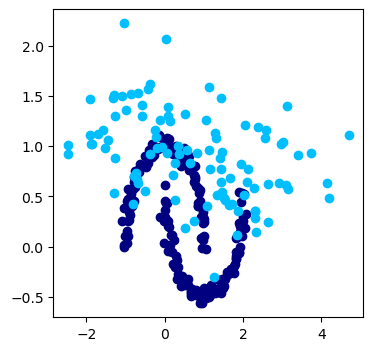

[21/100] 	Loss_D: -0.1385 	Loss_G: -0.7058
[22/100] 	Loss_D: -0.6172 	Loss_G: -0.2286
[23/100] 	Loss_D: -0.5752 	Loss_G: -0.1339
[24/100] 	Loss_D: -0.6309 	Loss_G: -0.3341
[25/100] 	Loss_D: -0.6635 	Loss_G: -0.2892
[26/100] 	Loss_D: -0.6735 	Loss_G: -0.4021
[27/100] 	Loss_D: -0.5480 	Loss_G: -0.3174
[28/100] 	Loss_D: -0.5163 	Loss_G: -0.3819
[29/100] 	Loss_D: -0.5915 	Loss_G: -0.3639
[30/100] 	Loss_D: -0.4980 	Loss_G: -0.3630


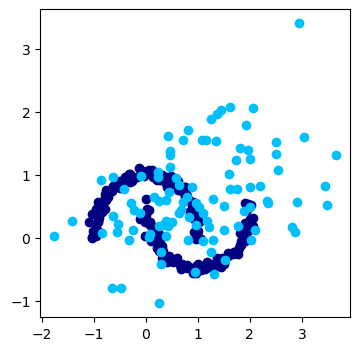

[31/100] 	Loss_D: -0.4967 	Loss_G: -0.5332
[32/100] 	Loss_D: -0.4985 	Loss_G: -0.4970
[33/100] 	Loss_D: -0.5178 	Loss_G: -0.4658
[34/100] 	Loss_D: -0.4212 	Loss_G: -0.4820
[35/100] 	Loss_D: -0.4402 	Loss_G: -0.4763
[36/100] 	Loss_D: -0.4453 	Loss_G: -0.4936
[37/100] 	Loss_D: -0.4065 	Loss_G: -0.4438
[38/100] 	Loss_D: -0.3822 	Loss_G: -0.5076
[39/100] 	Loss_D: -0.4322 	Loss_G: -0.5266
[40/100] 	Loss_D: -0.3102 	Loss_G: -0.5760


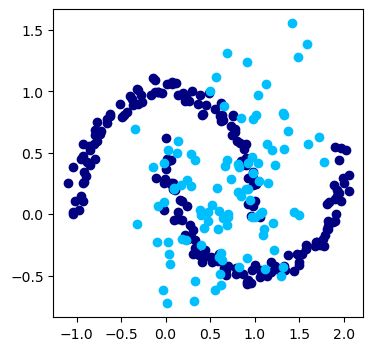

[41/100] 	Loss_D: -0.3175 	Loss_G: -0.6859
[42/100] 	Loss_D: -0.1627 	Loss_G: -0.7528
[43/100] 	Loss_D: -0.0786 	Loss_G: -0.9368
[44/100] 	Loss_D: -0.0215 	Loss_G: -0.9729
[45/100] 	Loss_D: 0.0014 	Loss_G: -0.9896
[46/100] 	Loss_D: 0.0006 	Loss_G: -0.9997
[47/100] 	Loss_D: -0.0175 	Loss_G: -0.9998
[48/100] 	Loss_D: -0.0071 	Loss_G: -0.9963
[49/100] 	Loss_D: -0.0575 	Loss_G: -0.9521
[50/100] 	Loss_D: -0.0267 	Loss_G: -0.9248


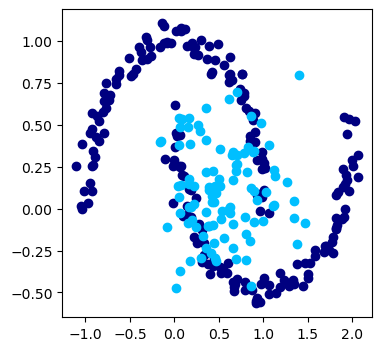

[51/100] 	Loss_D: -0.0900 	Loss_G: -0.8836
[52/100] 	Loss_D: -0.4525 	Loss_G: -0.1853
[53/100] 	Loss_D: -0.4596 	Loss_G: -0.1137
[54/100] 	Loss_D: -0.4579 	Loss_G: -0.1174
[55/100] 	Loss_D: -0.4440 	Loss_G: -0.1456
[56/100] 	Loss_D: -0.4070 	Loss_G: -0.1543
[57/100] 	Loss_D: -0.3940 	Loss_G: -0.1346
[58/100] 	Loss_D: -0.3392 	Loss_G: -0.1232
[59/100] 	Loss_D: -0.3612 	Loss_G: -0.1187
[60/100] 	Loss_D: -0.3599 	Loss_G: -0.2124


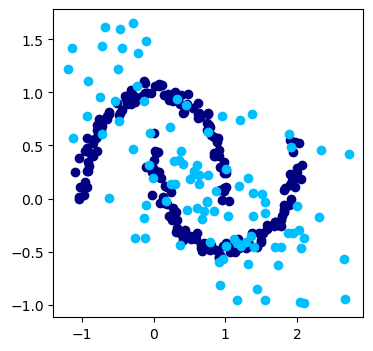

[61/100] 	Loss_D: -0.3007 	Loss_G: -0.2566
[62/100] 	Loss_D: -0.4142 	Loss_G: -0.3437
[63/100] 	Loss_D: -0.3376 	Loss_G: -0.3982
[64/100] 	Loss_D: -0.4114 	Loss_G: -0.3118
[65/100] 	Loss_D: -0.5154 	Loss_G: -0.3487
[66/100] 	Loss_D: -0.4619 	Loss_G: -0.3377
[67/100] 	Loss_D: -0.5010 	Loss_G: -0.3743
[68/100] 	Loss_D: -0.4422 	Loss_G: -0.3361
[69/100] 	Loss_D: -0.5724 	Loss_G: -0.2635
[70/100] 	Loss_D: -0.5100 	Loss_G: -0.3764


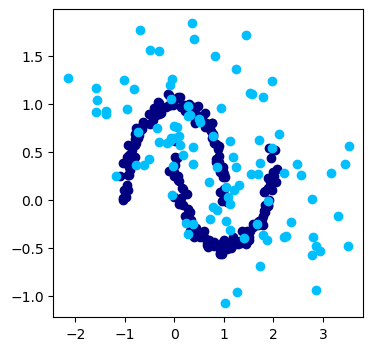

[71/100] 	Loss_D: -0.4628 	Loss_G: -0.3170
[72/100] 	Loss_D: -0.4234 	Loss_G: -0.2770
[73/100] 	Loss_D: -0.4286 	Loss_G: -0.2295
[74/100] 	Loss_D: -0.4556 	Loss_G: -0.3254
[75/100] 	Loss_D: -0.4772 	Loss_G: -0.3035
[76/100] 	Loss_D: -0.5234 	Loss_G: -0.3483
[77/100] 	Loss_D: -0.4404 	Loss_G: -0.3602
[78/100] 	Loss_D: -0.4223 	Loss_G: -0.3090
[79/100] 	Loss_D: -0.4512 	Loss_G: -0.2770
[80/100] 	Loss_D: -0.4378 	Loss_G: -0.1817


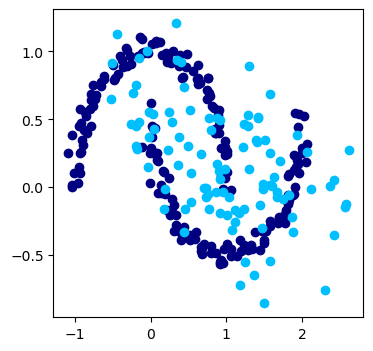

[81/100] 	Loss_D: -0.4558 	Loss_G: -0.1925
[82/100] 	Loss_D: -0.4998 	Loss_G: -0.2627
[83/100] 	Loss_D: -0.4403 	Loss_G: -0.1839
[84/100] 	Loss_D: -0.5000 	Loss_G: -0.2044
[85/100] 	Loss_D: -0.4674 	Loss_G: -0.2281
[86/100] 	Loss_D: -0.4392 	Loss_G: -0.2192
[87/100] 	Loss_D: -0.4843 	Loss_G: -0.2948
[88/100] 	Loss_D: -0.4822 	Loss_G: -0.1961
[89/100] 	Loss_D: -0.5227 	Loss_G: -0.2426
[90/100] 	Loss_D: -0.4983 	Loss_G: -0.2086


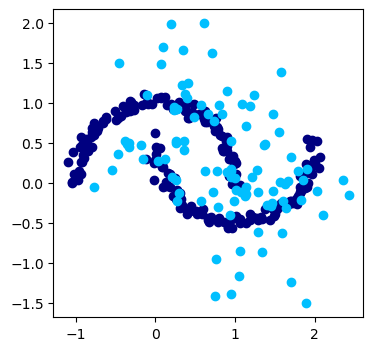

[91/100] 	Loss_D: -0.5340 	Loss_G: -0.2401
[92/100] 	Loss_D: -0.5045 	Loss_G: -0.2194
[93/100] 	Loss_D: -0.4908 	Loss_G: -0.2261
[94/100] 	Loss_D: -0.5357 	Loss_G: -0.1459
[95/100] 	Loss_D: -0.4900 	Loss_G: -0.3518
[96/100] 	Loss_D: -0.5539 	Loss_G: -0.3164
[97/100] 	Loss_D: -0.4402 	Loss_G: -0.2167
[98/100] 	Loss_D: -0.4715 	Loss_G: -0.2122
[99/100] 	Loss_D: -0.5035 	Loss_G: -0.2604


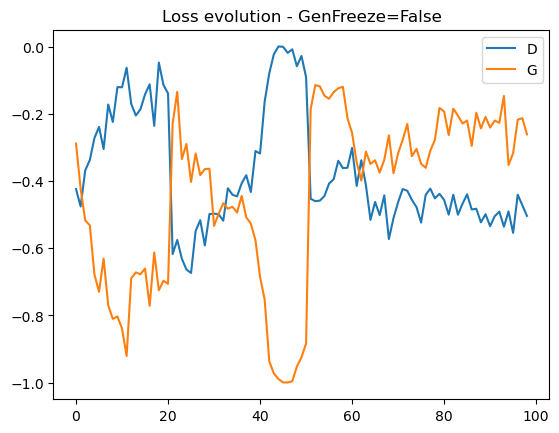

In [15]:
# Then, training both Discriminator and Generator

train_WGAN(GenFreeze=False, niterD=50, lrdisc=1e-3, iter_display=10, clip=True, n_epochs=100, clip_value=0.5)

Hum. Training failed with that set of parameters.

### WGAN-GP

Training WGAN - GenFreeze=True
Gradient penalty with lambda = 1.0
[1/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[2/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[3/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[4/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[5/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[6/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[7/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[8/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[9/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[10/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[11/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[12/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[13/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[14/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[15/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[16/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[17/50] 	Loss_D

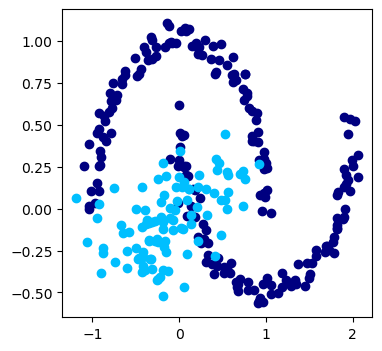

[21/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[22/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[23/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[24/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[25/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[26/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[27/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[28/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[29/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[30/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[31/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[32/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[33/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[34/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[35/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[36/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[37/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[38/50] 	Loss_

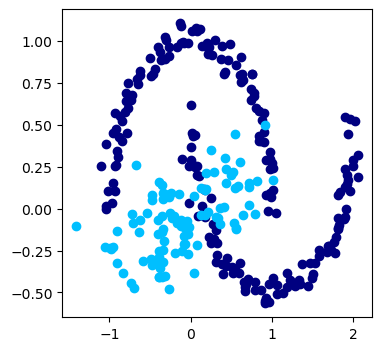

[41/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[42/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[43/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[44/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[45/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[46/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[47/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[48/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan
[49/50] 	Loss_D: nan 	Loss_G: nan 	Gradient_norm_est: nan


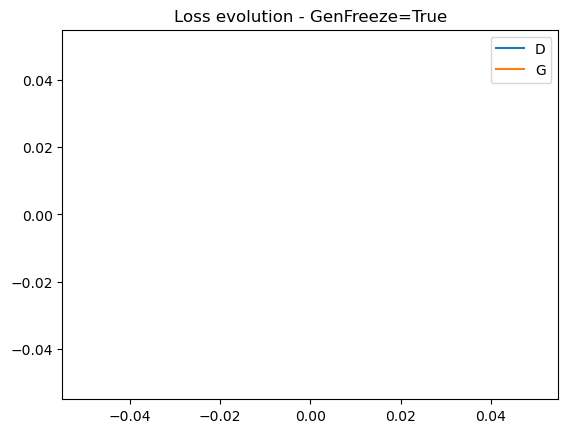

In [16]:
# First, training Discriminator with Generator frozen

train_WGAN(GenFreeze=True, lrdisc=1e-4, niterD=100, grad_penalty=True, n_epochs=50, lambd=1.0, iter_display=20)

Training WGAN - GenFreeze=False
Gradient penalty with lambda = 10.0
[1/50] 	Loss_D: 7.3705 	Loss_G: -0.4767 	Gradient_norm_est: 0.1432
[2/50] 	Loss_D: 5.4477 	Loss_G: -0.4564 	Gradient_norm_est: 0.2635
[3/50] 	Loss_D: 4.0429 	Loss_G: -0.4154 	Gradient_norm_est: 0.3669
[4/50] 	Loss_D: 3.1677 	Loss_G: -0.4293 	Gradient_norm_est: 0.4406
[5/50] 	Loss_D: 2.3035 	Loss_G: -0.4062 	Gradient_norm_est: 0.5212
[6/50] 	Loss_D: 1.9438 	Loss_G: -0.3989 	Gradient_norm_est: 0.5678
[7/50] 	Loss_D: 1.7964 	Loss_G: -0.3603 	Gradient_norm_est: 0.5745
[8/50] 	Loss_D: 1.4564 	Loss_G: -0.3995 	Gradient_norm_est: 0.6231
[9/50] 	Loss_D: 1.3175 	Loss_G: -0.4405 	Gradient_norm_est: 0.6408
[10/50] 	Loss_D: 1.1293 	Loss_G: -0.2893 	Gradient_norm_est: 0.6617
[11/50] 	Loss_D: 0.8800 	Loss_G: -0.3583 	Gradient_norm_est: 0.7067
[12/50] 	Loss_D: 0.9261 	Loss_G: -0.4501 	Gradient_norm_est: 0.7017
[13/50] 	Loss_D: 0.9909 	Loss_G: -0.3101 	Gradient_norm_est: 0.6933
[14/50] 	Loss_D: 0.7672 	Loss_G: -0.3572 	Gradient_norm_e

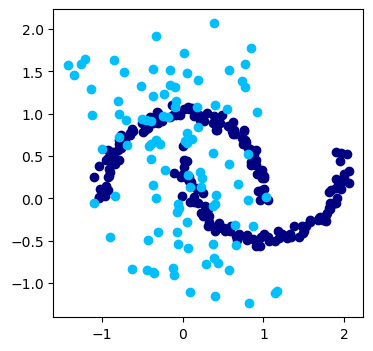

[21/50] 	Loss_D: 0.6115 	Loss_G: -0.3756 	Gradient_norm_est: 0.7742
[22/50] 	Loss_D: 0.5328 	Loss_G: -0.3944 	Gradient_norm_est: 0.7756
[23/50] 	Loss_D: 0.4945 	Loss_G: -0.3951 	Gradient_norm_est: 0.8043
[24/50] 	Loss_D: 0.6125 	Loss_G: -0.4675 	Gradient_norm_est: 0.7760
[25/50] 	Loss_D: 0.5820 	Loss_G: -0.3157 	Gradient_norm_est: 0.7725
[26/50] 	Loss_D: 0.6279 	Loss_G: -0.3751 	Gradient_norm_est: 0.7676
[27/50] 	Loss_D: 0.5827 	Loss_G: -0.4589 	Gradient_norm_est: 0.7873
[28/50] 	Loss_D: 0.6583 	Loss_G: -0.4197 	Gradient_norm_est: 0.7750
[29/50] 	Loss_D: 0.6911 	Loss_G: -0.4109 	Gradient_norm_est: 0.7439
[30/50] 	Loss_D: 0.5199 	Loss_G: -0.4612 	Gradient_norm_est: 0.8072
[31/50] 	Loss_D: 0.4883 	Loss_G: -0.3444 	Gradient_norm_est: 0.8181
[32/50] 	Loss_D: 0.5591 	Loss_G: -0.4104 	Gradient_norm_est: 0.7891
[33/50] 	Loss_D: 0.8784 	Loss_G: -0.4103 	Gradient_norm_est: 0.7259
[34/50] 	Loss_D: 0.3988 	Loss_G: -0.3918 	Gradient_norm_est: 0.8347
[35/50] 	Loss_D: 0.7556 	Loss_G: -0.3732 	Gradie

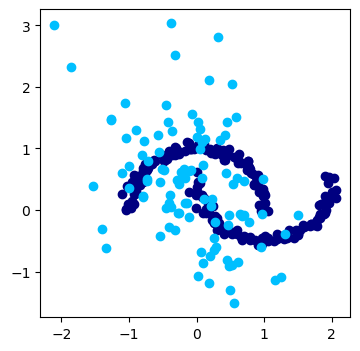

[41/50] 	Loss_D: 0.8978 	Loss_G: -0.3569 	Gradient_norm_est: 0.7275
[42/50] 	Loss_D: 0.6602 	Loss_G: -0.3391 	Gradient_norm_est: 0.7794
[43/50] 	Loss_D: 0.4841 	Loss_G: -0.4850 	Gradient_norm_est: 0.8262
[44/50] 	Loss_D: 0.9157 	Loss_G: -0.4279 	Gradient_norm_est: 0.7323
[45/50] 	Loss_D: 0.7544 	Loss_G: -0.4716 	Gradient_norm_est: 0.7676
[46/50] 	Loss_D: 0.7244 	Loss_G: -0.4155 	Gradient_norm_est: 0.7673
[47/50] 	Loss_D: 0.3179 	Loss_G: -0.4125 	Gradient_norm_est: 0.8517
[48/50] 	Loss_D: 0.7281 	Loss_G: -0.4868 	Gradient_norm_est: 0.7631
[49/50] 	Loss_D: 0.7045 	Loss_G: -0.4265 	Gradient_norm_est: 0.7751


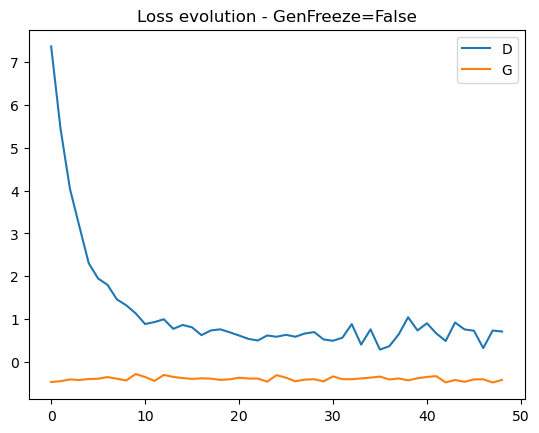

In [17]:
# Then, trying to train both Discriminator and Generator.

train_WGAN(GenFreeze=False, lrdisc=1e-4, niterD=100, lrgen=1e-4, grad_penalty=True, lambd=10.0, n_epochs=50, iter_display=20)

Still very difficult to train anything. Highly sensitive to initializations.

### VAE

We code here a very simple VAE. 

The Encoder is going to encode from $\mathbb{R}^2$ into $\mathbb{R}^d$ (ie dim-d latent space), and decoder from $\mathbb{R}^d$ to $\mathbb{R}^2$.

The loss is the usual ELBO with a closed-form expression of the KL.

In [18]:
class Encoder(nn.Module):
    
    def __init__(self, n_neurons=16, latent_dim=2):
        super(Encoder, self).__init__()
        
        self.fc1 = nn.Linear(2, n_neurons) # input dim = 2
        self.fc2 = nn.Linear(n_neurons, n_neurons)
        self.fc_mu = nn.Linear(n_neurons, latent_dim)
        self.fc_logvar = nn.Linear(n_neurons, latent_dim)
        
    def forward(self,x):
        # x : B x 2
        # print(f"entrée encodeur = {x}")
        x = F.relu(self.fc1(x)) # B x n_neurons
        # print(f"1ere layer encodeur = {x}")
        x = F.relu(self.fc2(x)) # B x n_neurons
        # print(f"2e layer encodeur = {x}")
        mu = self.fc_mu(x) # B x latent_dim : mu's of the Gaussians
        # print(f"sortie mu encodeur = {mu}")
        logvar = self.fc_logvar(x) # B x latent_dim : covariance matrix (assumed diagonal) of the Gaussians
        # print(f"sortie logvar encodeur = {logvar}")
        
        return mu, logvar

In [19]:
class Decoder(nn.Module):
    
    def __init__(self, n_neurons=16, latent_dim=2):
        super(Decoder, self).__init__()
        
        self.fc1 = nn.Linear(latent_dim, n_neurons)
        self.fc2 = nn.Linear(n_neurons, n_neurons)
        self.fc3 = nn.Linear(n_neurons, 2)
        
    def forward(self,z):
        # z : B x latent_dim
        z = F.relu(self.fc1(z)) # B x n_neurons
        z = F.relu(self.fc2(z)) # B x n_neurons
        z = self.fc3(z) # B x 2
        # print(f"z_decoder = {z}")
        x_hat = z # B x 2 in [0,1]^2
        # print(f"x_hat = sigmoid(z_decoder) = {x_hat}")
        
        return x_hat

In [20]:
class ToyVAE(nn.Module):
    
    def __init__(self, n_neurons=16, latent_dim=2): #, scale=1.0):
        super(ToyVAE, self).__init__()
        
        self.encoder = Encoder(n_neurons=n_neurons, latent_dim=latent_dim)
        self.decoder = Decoder(n_neurons=n_neurons, latent_dim=latent_dim)
        # self.scale = scale
        
    def rsample(self, mean, std): #, scale=None):
        # mean : B x latent_dim
        # std : B x latent_dim
        # if scale is None:
        #     scale=self.scale
        epsilon = torch.randn_like(mean) # N(0,1) shape B x latent_dim 
        z = mean + std * epsilon # * scale # B x 1 \sim \mathcal{N}(mu, var)
        return z
    
    def forward(self,x):
        mu, logvar = self.encoder(x)
        std = torch.exp(0.5 * logvar)
        # print(f"entrée de rsample : mu = {mu}")
        # print(f"entrée de rsample : std = {std}")
        z = self.rsample(mu, std)
        # print(f"sortie de rsample = {z}")
        # print(f"z samplé = {z}")
        x_hat = self.decoder(z)
        
        return x_hat, mu, logvar

In [21]:
def vae_loss(x, x_hat, mean, logvar, kl_weight=0.5):
    
    # mse = nn.MSELoss(reduction='mean')
    # reconstruction_loss = mse(x, x_hat)
    reconstruction_loss = torch.mean(torch.sum( (x-x_hat)**2, axis=1 ))
    kl_loss = - 0.5 * torch.sum( 1 + logvar - mean**2 - logvar.exp())
    
    # return reconstruction_loss + kl_loss, kl_loss, reconstruction_loss
    
    return (1-kl_weight)*(reconstruction_loss) + kl_weight*kl_loss, kl_loss, reconstruction_loss

### VAE Training loop

In [22]:
X_data = X_data.to(device)

def train_VAE(
    X_data = X_data,
    n_epochs = 10,
    optimizer = None,
    model = None,
    kl_weight = 0.5
):
    
    print(f"Start training {n_epochs} epochs")
    rec_losses = []
    kl_losses = []
    losses = []
    
    # model.train()
    
    for epoch in range(n_epochs):
        # forward pass
        x_hat, mean, logvar = model(X_data)
        # backward pass
        optimizer.zero_grad()
        # print(x_hat)
        loss, kl_loss, rec_loss = vae_loss(X_data, x_hat, mean, logvar, kl_weight)
        loss.backward()
        optimizer.step()
        # reporting out
        losses.append(loss.item())
        kl_losses.append(kl_loss.item())
        rec_losses.append(rec_loss.item())
        print(f"Epoch {epoch+1} / {n_epochs} -- loss = {loss.item():.4f} -- rec_loss = {rec_loss.item():.4f} -- kl_loss = {kl_loss.item():.4f}") #, end="\r")
        
    return losses, rec_losses, kl_losses  

Checking basic AutoEncoding - we set scale at 0, so the model beahaves as a simple AutoEncoder

In [23]:
LATENT_DIM = 8

vae = ToyVAE(latent_dim=LATENT_DIM).to(device)
lr = 1e-2

optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

Start training 100 epochs
Epoch 1 / 100 -- loss = 1.5432 -- rec_loss = 1.5431 -- kl_loss = 68.6369
Epoch 2 / 100 -- loss = 1.3710 -- rec_loss = 1.3710 -- kl_loss = 73.1680
Epoch 3 / 100 -- loss = 1.2605 -- rec_loss = 1.2604 -- kl_loss = 85.5306
Epoch 4 / 100 -- loss = 1.1557 -- rec_loss = 1.1556 -- kl_loss = 105.6062
Epoch 5 / 100 -- loss = 1.0516 -- rec_loss = 1.0514 -- kl_loss = 135.7909
Epoch 6 / 100 -- loss = 1.0158 -- rec_loss = 1.0156 -- kl_loss = 180.1828
Epoch 7 / 100 -- loss = 0.9833 -- rec_loss = 0.9830 -- kl_loss = 245.0830
Epoch 8 / 100 -- loss = 0.8917 -- rec_loss = 0.8914 -- kl_loss = 320.9942
Epoch 9 / 100 -- loss = 0.8727 -- rec_loss = 0.8723 -- kl_loss = 402.5084
Epoch 10 / 100 -- loss = 0.7683 -- rec_loss = 0.7678 -- kl_loss = 498.3171
Epoch 11 / 100 -- loss = 0.7598 -- rec_loss = 0.7592 -- kl_loss = 593.6323
Epoch 12 / 100 -- loss = 0.6336 -- rec_loss = 0.6330 -- kl_loss = 669.1995
Epoch 13 / 100 -- loss = 0.5744 -- rec_loss = 0.5737 -- kl_loss = 751.6076
Epoch 14 / 

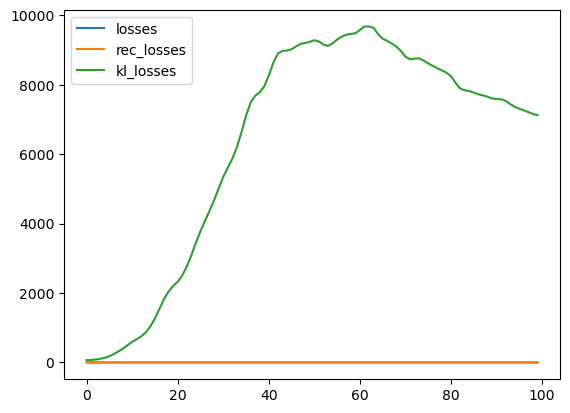

In [24]:
losses, rec_losses, kl_losses = train_VAE(X_data, optimizer=optimizer, model=vae, n_epochs=100, kl_weight=1e-6)
plt.plot(losses, label='losses')
plt.plot(rec_losses, label='rec_losses')
plt.plot(kl_losses, label='kl_losses')
plt.legend()
plt.show()

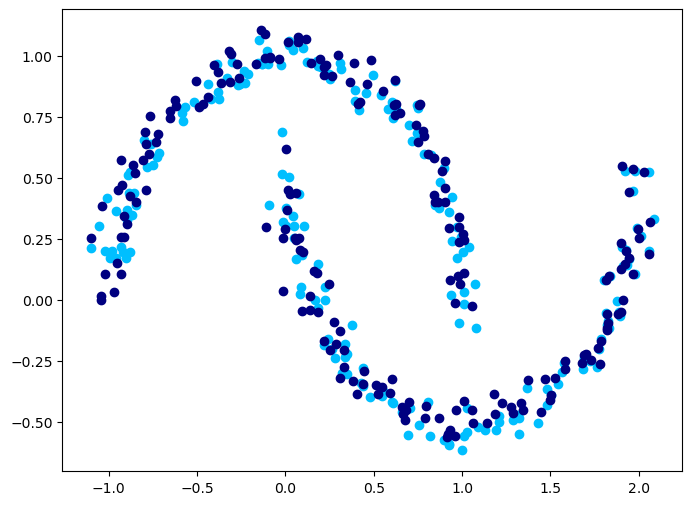

In [25]:
vae.eval()

with torch.no_grad():
    X_hat_data, mu, log_var = vae(X_data)
    
display(X_data.cpu(), X_hat_data.cpu())

### Q2.a

- GANs are difficult to train by definition of their loss function, composed of KL divergences. See above.
- WGANs bring some improvement, but the Lipschitz constraint on the discriminator is difficult to enforce. When using weigh_clipping, the clip value is hard to tune. When using gradient penalty, the weight on the gradient penalty is hard to turn.
- VAE proved surprinsigly difficult to tune, even on the two-moons toy case. If the weight on the KL-loss is too strong, then the algorithm will collapse the outputs to 0, as this actually minimizes the KL-divergence of the latent variable. This is probably due to the fact that the original data lies in $\mathbb{R}^2$, and it makes little sense to encode into a higher dimension latent space.

### Q2.b

- It is clear from the drawings that the generators of the GANs and WGANs are not doing a good job at covering the data distribution. This was clear as the training of the models was not satisfactory.
- In the case of the VAE, the plot shows a much better coverage. However, this is not truly satisfactory, as we are using a latent space of higher dimension that the data space.

# MNIST

### Dataloader, etc.

In [26]:
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
import torchvision.utils as vutils
import torch.utils.data as data
from torch.utils.data import Subset

import os

In [27]:
print(os.getcwd())

/home/benjamin.deporte/MVA/TP_GenAI_MVA_2025_02_25/notebooks


In [28]:
batch_size=128 # can go to 4096+ for RTX 3080
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

datapath = '/home/benjamin.deporte/MVA/TP_GenAI_MVA_2025_02_25/data'  # setup IRT
# datapath = '/home/benjamin/Folders_Python/TP_GenAI_MVA_2025_02_25/data'  # setup CPU local
train_set = MNIST(datapath, train=True, transform=transform, download=True)
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

In [29]:
# Displaying function
def imshow(img,size=None):
    img = img*0.5 + 0.5     # unnormalize
    if size is not None:
      img = transforms.Resize(size=size, interpolation=transforms.InterpolationMode.NEAREST, antialias=True)(img)
    pil_img = torchvision.transforms.functional.to_pil_image(img)
    plt.imshow(pil_img)
    # print("Image size (h x w): ",  pil_img.height, "x", pil_img.width)
    return None

torch.Size([128, 1, 28, 28])


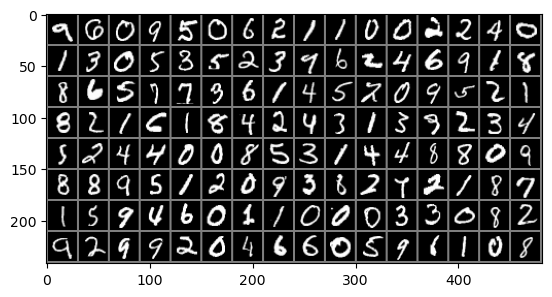

In [30]:
real,_ = next(iter(train_loader))
print(real.shape)

pil_img = imshow(torchvision.utils.make_grid(real.to('cpu'),nrow=16))

### WGAN

In [31]:
# Size  of generator input
nz = 100

# Size of feature maps in generator and discriminator
ngf, ndf = 64, 64

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels = nz, out_channels = ngf * 8, kernel_size = 4, stride = 1, padding = 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(in_channels = ngf * 8, out_channels = ngf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(in_channels = ngf * 4, out_channels = ngf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(in_channels = ngf * 2, out_channels = ngf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels = ngf, out_channels = 1, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
            # output size. 1 x 28 x 28
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input is 1 x 28 x 28
            nn.Conv2d(in_channels = 1, out_channels = ndf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 15 x 15
            nn.Conv2d(in_channels = ndf, out_channels= ndf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(in_channels = ndf * 2, out_channels = ndf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 5 x 5
            nn.Conv2d(in_channels = ndf * 4, out_channels = 1, kernel_size = 4, stride = 2, padding = 1, bias=False)
        )
        self.prob = nn.Sigmoid()

    def forward(self, input):
        return self.prob(self.main(input).view(-1, 1).squeeze(1))

# Create some generator and discriminator
G = Generator().to(device)
D = Discriminator().to(device)

### Display samples of the Generator

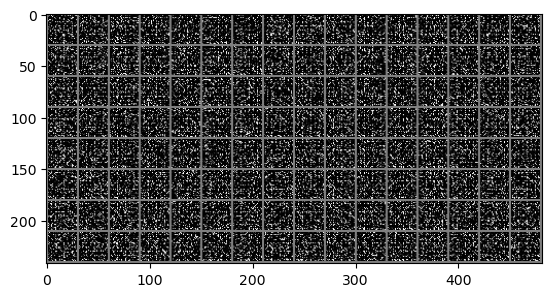

In [32]:
# function to display samples of the generator
def show(G,z=None,batch_size=128,nz=100):
  # provide random latent code as option to see evolution
  with torch.no_grad():
    if z==None:
      z = torch.randn(batch_size,nz,1,1).to(device)
      # print(f"z = {z.size()}")
    genimages = G(z)
    pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=16))
    return(pil_img)

# Load a pre-learned generator to see what you will get at the end of the practical session!:
G = Generator().to(device)
# G.load_state_dict(torch.hub.load_state_dict_from_url('https://perso.telecom-paristech.fr/aleclaire/mva/tp/wgan_epoch100.pt', progress=False))

# Display samples
show(G)

### Weigths Initialization

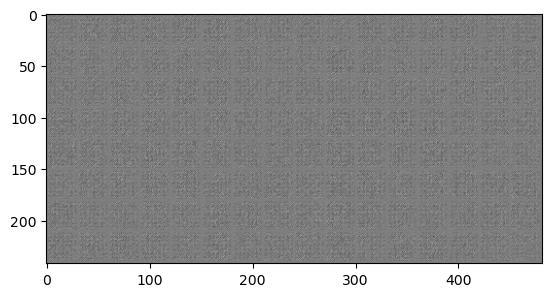

In [33]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Create the generator and discriminator
G = Generator().to(device)
D = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02.
G.apply(weights_init);
D.apply(weights_init);

show(G)

### Specific Training loop - WGAN with Gradient Penalty for MNIST

In [34]:
# small dataloader to test the pipeline

# N_SMALL = 500
# subset_indices = range(N_SMALL)
# subset = Subset(train_set, subset_indices)

# sample_loader = data.DataLoader(subset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

In [35]:
def est_gradient_norm(n_samples=10):
    # Estimate Gradient of Discriminator on n_samples points
            
    # Sample points from the generator
    z = torch.randn(n_samples,nz,1,1).to(device)
    x_fake_sampled = G(z) # shape : N x 1 x 28 x 28
    # print(f"x_real = {x_real.size()}")
    # print(f"x_fake_sampled = {x_fake_sampled.size()}")
            
    # # Calculate interpolation between data and generated points
    alpha = torch.rand((n_samples,1,1,1),device=device) # N x 1 x 1 x 1
    # print(f"alpha = {alpha.size()}")
    # print(f"exemple alpha = {alpha[0]}")
    interp = (alpha * x_fake_sampled + (1-alpha) * x_real[:n_samples,:,:,:]) # N x 1 x 28 x 28
    # print(f"interp = {interp.size()}")
    interp.requires_grad_()
            
    D_interp = D(interp) # N x 1
    # print(f"D_interp = {D_interp.size()}")
    gradout = torch.ones(D_interp.size()).to(device) # N x 1
    # print(f"gradouts = {gradout.size()}") # N x 1
    # autograd will actually compute a Gradient tensor N x 1 x 28 x 28, 
    # as output is D_interp shape B
    # and input is interp shape N x 1 x 28 x 28
    # ----
    # gradients is shape N x 1 x 28 x 28
    gradients = torch.autograd.grad(outputs = D_interp, inputs = interp, grad_outputs = gradout, create_graph = True, retain_graph = True)[0] # N x 1 x 28 x 28
    # print(f"gradients = {gradients.size()}")
    # -----
    # compute gradient norm estimate
    norms_squared = torch.sqrt(torch.sum(gradients**2,(2,3))) # B x 1 
    # print(f"norms_squared = {norms_squared.size()}")
    est_gradient_norm = torch.mean(norms_squared) #  1
    # print(est_gradient_norm)
    
    return est_gradient_norm

# est_gradient_norm()

In [36]:
torch.manual_seed(1)  # initialize random seed for reproducibility

num_epochs = 20
log_every = 100
gpw = 5

G = Generator().to(device)
D = Discriminator().to(device)
G.apply(weights_init);
D.apply(weights_init);
optimD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

niterD = 10

epoch : 1 / 20         --- loss D sans GP = -0.0115         --- loss G = -0.9699         --- gradient norm = 0.9686                                                                 
epoch : 2 / 20         --- loss D sans GP = -0.0045         --- loss G = -0.9886         --- gradient norm = 0.9810                                                                 
epoch : 3 / 20         --- loss D sans GP = 0.0003         --- loss G = -1.0000         --- gradient norm = 0.9974                                                                 
epoch : 4 / 20         --- loss D sans GP = -0.0989         --- loss G = -0.8960         --- gradient norm = 0.9907                                                                 
epoch : 5 / 20         --- loss D sans GP = -0.3872         --- loss G = -0.5972         --- gradient norm = 0.9810                                                                 
epoch : 6 / 20         --- loss D sans GP = 0.0003         --- loss G = -1.0000         --- grad

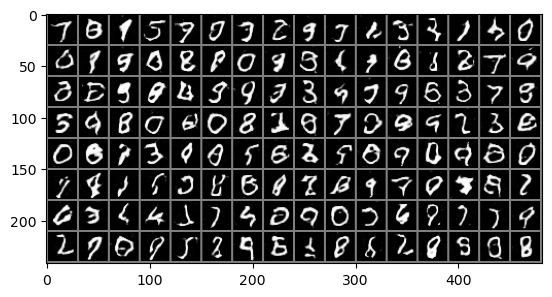

In [ ]:
t0 = time.time()
list_gradient_norms = []
Dlosses = []
Dlosses_wogp = []
Glosses = []
Gradient_norms = []

for epoch in range(num_epochs):
    # For each batch in the train_loader
    losses_d_batch = []
    losses_d_wogp_batch = []
    losses_g_batch = []
    gradient_norms_batch = []
    
    for i, batch in enumerate(train_loader, 0):
         
        # losses_batch = []
        # gradient_norm_batch = []

        ############################
        # Draw Batches 
        ############################
        
        x_real = batch[0].to(device)  # B x 1 x 28 x 28
        # print(f"x_real = {x_real.size()}")
        
        x_fake = G(torch.randn(batch_size,nz,1,1).to(device)) # B x 1 x 28 x 28
        # print(f"x_fake = {x_fake.size()}")
        
        ################################
        # Train Discriminator 
        ################################
        
        for j in range(niterD):
            # print(f"Discriminator training {j+1} / {niterD}", end="\r")
            
            optimD.zero_grad()
            # Dloss sans gradient penalty : best is -1, worst is 1
            # loss sans la régul gradient penalty
            Dloss_wogp = - (torch.mean(D(x_real)) - torch.mean(D(x_fake)))
            
            gradient_norm = est_gradient_norm()
            
            # calculate the loss with gradient penalty
            Dloss = Dloss_wogp + gpw * (gradient_norm - 1)**2
                        
            # optimize
            optimD.zero_grad()
            Dloss.backward(retain_graph=True)
            optimD.step()
          
        # iteration losses log
        losses_d_wogp_batch.append(Dloss_wogp.item())
        losses_d_batch.append(Dloss.item())
        gradient_norms_batch.append(gradient_norm.item())
    
        ############################
        # Update G network
        ############################
        
        # Gloss : best is -1, worst is 0
        Gloss = - torch.mean(D(G(torch.randn(batch_size,nz,1,1).to(device))))
        optimG.zero_grad()
        Gloss.backward()
        optimG.step()
        
        losses_g_batch.append(Gloss.item())
        
        # reporting
        print(f"batch {i+1} / {len(train_loader)} \
            -- avg D loss sans GP = {np.average(losses_d_wogp_batch):.4f} \
            -- avg G loss = {np.average(losses_g_batch):.4f} \
            -- Gradient norm estimate : {gradient_norm:.4f}", \
            end="\r")
        
        ##############################
        ## Log 
        ##############################
        
    loss_d_wogp_epoch = np.average(losses_d_wogp_batch)
    loss_d_epoch = np.average(losses_d_batch)
    loss_g_epoch = np.average(losses_g_batch)
    gradient_norm_epoch = np.average(gradient_norms_batch)
    
    Dlosses_wogp.append(loss_d_wogp_epoch)
    Dlosses.append(loss_d_epoch)
    Glosses.append(loss_g_epoch)
    Gradient_norms.append(gradient_norm_epoch)
       
    print(f"epoch : {epoch+1} / {num_epochs} \
        --- loss D sans GP = {loss_d_wogp_epoch:.4f} \
        --- loss G = {loss_g_epoch:.4f} \
        --- gradient norm = {gradient_norm_epoch:.4f} \
                                                                ")
    

with torch.no_grad():
    z = torch.randn(batch_size,nz,1,1).to(device)
    genimages = G(z)
    pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=16))

tlt = time.time()-t0
print(f'Total learning time = {tlt:.4f}')

# # Save final generator in a variable for later use
# wgan = Generator()
# wgan.load_state_dict(G.state_dict())

# # Save final generator in a file
# torch.save(G.state_dict(), 'Deporte_wgan.pt')

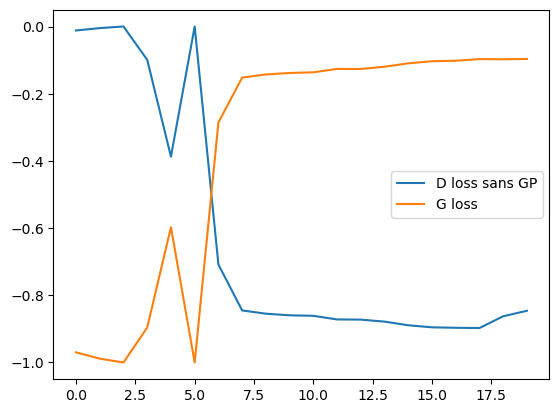

In [38]:
plt.plot(Dlosses_wogp, label="D loss sans GP")
plt.plot(Glosses, label='G loss')
plt.legend()

plt.show()

# VAE

In [39]:
latent_dim = 2
hidden_dim = 288

In [40]:
class Encoder2D(nn.Module):
        def __init__(self, latent_dim=latent_dim):
                super(Encoder2D, self).__init__()
                self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
                self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
                self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=7, padding=3)
                n = hidden_dim # 32 x 3 x 3
                self.fc_mu = nn.Linear(n, latent_dim)
                self.fc_logvar = nn.Linear(n, latent_dim)
                
        def forward(self,inputs):
                # input is B x 1 x 28 x 28
                x = self.conv1(inputs) # out : B x 16 x 28 x 28
                x = F.relu(nn.AvgPool2d(2)(x)) # out : B x 16 x 14 x 14
                x = self.conv2(x) # out : batch x 32 x 14 x 14
                x = F.relu(nn.AvgPool2d(2)(x)) # out : B x 32 x 7 x 7
                x = self.conv3(x) # out : B x 32 x 7 x 7
                x = F.relu(nn.AvgPool2d(2)(x)) # out : B x 32 x 3 x 3
                x = x.view((x.size()[0], -1)) # out : B x 288
                mu_x = self.fc_mu(x) # out : B x latent_dim
                logvar_x = self.fc_logvar(x) # out : B x latent_dim
                return mu_x, logvar_x
        
# encoder = Encoder2D()

In [41]:
class EncoderMLP(nn.Module):
        def __init__(self, latent_dim=latent_dim, n_neurons=32):
                super(EncoderMLP, self).__init__()
                self.fc1 = nn.Linear(1*28*28, n_neurons)
                self.fc2 = nn.Linear(n_neurons, n_neurons)
                self.fc3 = nn.Linear(n_neurons, n_neurons)
                self.fc_mu = nn.Linear(n_neurons, latent_dim)
                self.fc_logvar = nn.Linear(n_neurons, latent_dim)
                
        def forward(self,inputs):
                # input is B x 1 x 28 x 28
                x = inputs.view(inputs.size()[0],-1)                # x = self.deconv1(x) # out : B x 32 x 3 x 3
                # x = self.deconv2(x) # out : B x 32 x 6 x 6
                # x = self.deconv3(x) # out : B x 32 x 12 x 12
                # x = self.deconv4(x) # out : B x 32 x 28 x 28
                x = F.relu(self.fc1(x)) # out : B x 16 x 14 x 14
                x = F.relu(self.fc2(x)) # out : B x 32 x 7 x 7
                x = F.relu(self.fc3(x)) 
                mu_x = self.fc_mu(x) # out : B x latent_dim
                logvar_x = self.fc_logvar(x) # out : B x latent_dim

                return mu_x, logvar_x
        
encoder = EncoderMLP()

In [42]:
# checking dimensions...
# 
batch_example_size = 8

x = torch.randn((batch_example_size,1,28,28))
print(f"input = {x.shape}")

mu, logvar = encoder(x)
print(f"output mu = {mu.shape}")
print(f"output logvar = {logvar.shape}")

input = torch.Size([8, 1, 28, 28])
output mu = torch.Size([8, 2])
output logvar = torch.Size([8, 2])


In [43]:
# # Decoder to sample back from vector latent_dim to 28 x 28

class Decoder2D(nn.Module):
        def __init__(self, latent_dim=latent_dim):
                super(Decoder2D, self).__init__()
                n_hidden = hidden_dim
                # print(f"entrée de rsample : mu = {mu.size()}")
                # print(f"entrée de rsample : std = {std.size()}")    
                self.fc1 = nn.Linear(latent_dim, n_hidden)
                self.deconv1 = nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1)
                self.deconv2 = nn.ConvTranspose2d(32, 32, kernel_size=5, stride=2, padding=2, output_padding=1)
                self.deconv3 = nn.ConvTranspose2d(32, 32, kernel_size=5, stride=2, padding=2, output_padding=1)
                self.deconv4 = nn.ConvTranspose2d(32, 1, kernel_size=7, stride=2, padding=1, output_padding=1)
                
        def forward(self, inputs):
                B = inputs.size(0)  # number of batches
                x = inputs # out = B x latent_dim
                x = F.relu(self.fc1(x)) # out : B x (hidden_dim)
                x = x.reshape(x.shape[0], 32, 3, 3) # out B * 32 * 3 * 3
                x = self.deconv1(x) # out : B x 32 x 3 x 3
                x = self.deconv2(x) # out : B x 32 x 6 x 6
                x = self.deconv3(x) # out : B x 32 x 12 x 12
                x = self.deconv4(x) # out : B x 32 x 28 x 28
                
                return x
        
# # decoder = Decoder2D()

In [44]:
# Decoder to sample back from vector latent_dim to 28 x 28

class DecoderMLP(nn.Module):
        def __init__(self, latent_dim=latent_dim, n_neurons=32):
                super(DecoderMLP, self).__init__()

                self.fc1 = nn.Linear(latent_dim, n_neurons)
                self.fc2 = nn.Linear(n_neurons, n_neurons)
                self.fc3 = nn.Linear(n_neurons, 1*28*28)
                
        def forward(self, inputs):
                x = F.relu(self.fc1(inputs))
                x = F.relu(self.fc2(x))
                x = self.fc3(x)
                x = x.view(x.size()[0],1,28,28)
                x = F.tanh(x)
                
                return x
        
decoder = DecoderMLP()

In [45]:
# check dimensions

x = torch.randn(8, latent_dim) # B (batch size) x latent_dim
print(f"input shape = {x.shape}")
out = decoder(x)
print(f"output shape = {out.shape}")

input shape = torch.Size([8, 2])
output shape = torch.Size([8, 1, 28, 28])


In [46]:
class MnistVAE(nn.Module):
    
    def __init__(self, n_neurons=16, latent_dim=2): #, scale=1.0):
        super(MnistVAE, self).__init__()
        
        self.encoder = EncoderMLP(latent_dim=latent_dim)
        self.decoder = DecoderMLP(latent_dim=latent_dim)
        # self.scale = scale
        
    def rsample(self, mean, std): #, scale=None):
        # mean : B x latent_dim
        # std : B x latent_dim
        # if scale is None:
        #     scale=self.scale
        epsilon = torch.randn_like(mean) # N(0,1) shape B x latent_dim 
        z = mean + std * epsilon # * scale # B x 1 \sim \mathcal{N}(mu, var)
        return z
    
    def forward(self,x):
        mu, logvar = self.encoder(x)
        std = torch.exp(0.5 * logvar) # we scale by sqrt(diag(var))
        # print(f"entrée de rsample : mu = {mu.size()}")
        # print(f"entrée de rsample : std = {std.size()}")
        z = self.rsample(mu, std)
        # print(f"z samplé = {z.size()}")
        x_hat = self.decoder(z)
        
        return x_hat, mu, logvar

In [47]:
# check dimensions
mvae = MnistVAE(latent_dim=latent_dim)

x = torch.randn(128, 1, 28, 28) # B (batch size) x 1 x 28 x 28

print(f"input shape = {x.shape}")

x_hat, mu, logvar = mvae(x)

print(f"outputs shapes : x_hat = {x_hat.size()}, mus = {mu.size()},  logvars = {logvar.size()}")

input shape = torch.Size([128, 1, 28, 28])
outputs shapes : x_hat = torch.Size([128, 1, 28, 28]), mus = torch.Size([128, 2]),  logvars = torch.Size([128, 2])


In [48]:
def mnist_vae_loss(x, x_hat, mean, logvar, kl_weight=0.5):
    
    reconstruction_loss = torch.mean(torch.sum( (x-x_hat)**2, axis=[1,2,3] ))
    kl_loss = - 0.5 * torch.sum( 1 + logvar - mean**2 - logvar.exp()) # validé
    
    # print(f"reconstruction loss = {reconstruction_loss}")
    # print(f"KL loss = {kl_loss}")
    
    return (1-kl_weight)*(reconstruction_loss) + kl_weight*kl_loss, kl_loss, reconstruction_loss

In [49]:
l = mnist_vae_loss(x, x_hat, mu, logvar)
print(f"Total loss = {l}")

Total loss = (tensor(406.6802, grad_fn=<AddBackward0>), tensor(1.1124, grad_fn=<MulBackward0>), tensor(812.2480, grad_fn=<MeanBackward0>))


### MNIST VAE Training Loop

In [50]:
def train_MNIST_VAE(
    loader = None,
    n_epochs = 10,
    optimizer = None,
    model = None,
    kl_weight = 0.5
):
    """_summary_

    Args:
        loader (_type_, optional): sample_loader ou train_loader. Defaults to None.
        n_epochs (int, optional): _description_. Defaults to 10.
        optimizer (_type_, optional): _# Decoder to sample back from vector latent_dim to 28 x 28

class Decoder2D(nn.Module):
        def __init__(self, latent_dim=latent_dim):
                super(Decoder2D, self).__init__()
                n_hidden = hidden_dim
                # print(f"entrée de rsample : mu = {mu.size()}")
                # print(f"entrée de rsample : std = {std.size()}")    self.fc1 = nn.Linear(latent_dim, n_hidden)
                self.deconv1 = nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1)
                self.deconv2 = nn.ConvTranspose2d(32, 32, kernel_size=5, stride=2, padding=2, output_padding=1)
                self.deconv3 = nn.ConvTranspose2d(32, 32, kernel_size=5, stride=2, padding=2, output_padding=1)
                self.deconv4 = nn.ConvTranspose2d(32, 1, kernel_size=7, stride=2, padding=1, output_padding=1)
                
        def forward(self, inputs):
                B = inputs.size(0)  # number of batches
                x = inputs # out = B x latent_dim
                x = F.relu(self.fc1(x)) # out : B x (hidden_dim)
                x = x.reshape(x.shape[0], 32, 3, 3) # out B * 32 * 3 * 3
                x = self.deconv1(x) # out : B x 32 x 3 x 3
                x = self.deconv2(x) # out : B x 32 x 6 x 6
                x = self.deconv3(x) # out : B x 32 x 12 x 12
                x = self.deconv4(x) # out : B x 32 x 28 x 28
                
                return x
        
decoder = Decoder2D()description_. Defaults to None.
        model (_type_, optional): _description_. Defaults to None.
        kl_weight (float, optional): _description_. Defaults to 0.5.

    Returns:
        _type_: lists of losses
    """
    
    print(f"Start training {n_epochs} epochs on MNIST VAE")
    rec_losses = []
    kl_losses = []
    total_losses = []
    
    # model.train()
    
    for epoch in range(n_epochs):
        
        # init batch measurements
        batch_kl_losses = []
        batch_rec_losses = []
        batch_total_losses = []
        
        for i, batch in enumerate(loader, 0):
            
            # forward pass
            x = batch[0]
            x_hat, mean, logvar = model(x)
            
            # backward pass
            optimizer.zero_grad()
            # print(x_hat)
            total_loss, kl_loss, rec_loss = mnist_vae_loss(x, x_hat, mean, logvar, kl_weight)
            total_loss.backward()
            optimizer.step()
            
            # logging at batch level
            batch_kl_losses.append(kl_loss.item())
            batch_rec_losses.append(rec_loss.item())
            batch_total_losses.append(total_loss.item())
            
            # reporting out at batch level
            print(f"Batch {i+1} / {len(loader)} \
            -- total loss = {batch_total_losses[-1]:.4f} \
            -- reco loss = {batch_rec_losses[-1]:.4f} \
            -- KL loss = {batch_kl_losses[-1]:.4f}", \
            end="\r")
            
        # logging at epoch level
        total_losses.append(np.average(batch_total_losses))  
        rec_losses.append(np.average(batch_rec_losses)) 
        kl_losses.append(np.average(batch_kl_losses)) 
        
        # reporting out at epoch level
        print(f"Epoch {epoch+1} / {n_epochs} \
            -- loss = {total_losses[-1]:.4f} \
            -- rec_loss = {rec_losses[-1]:.4f} \
            -- kl_loss = {kl_losses[-1]:.4f} \
                                           "
        ) #, end="\r")
        
    return total_losses, rec_losses, kl_losses  

### Training VAE

In [51]:
# small dataloader to test the pipeline

# N_SMALL = 1000
# subset_indices = range(N_SMALL)
# subset = Subset(train_set, subset_indices)

# sample_loader = data.DataLoader(subset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

In [52]:
latent_dim = 2
mnist_vae = MnistVAE(latent_dim=latent_dim)

lr = 1e-2
optimizer = torch.optim.Adam(mnist_vae.parameters(), lr=lr)

In [53]:
n_epochs = 50
kl_weight = 0.5

total_losses, rec_losses, kl_losses = train_MNIST_VAE(
    loader=train_loader, 
    n_epochs=n_epochs, 
    optimizer=optimizer, 
    model=mnist_vae,
    kl_weight=kl_weight
    )

Start training 50 epochs on MNIST VAE
Epoch 1 / 50             -- loss = 109.6279             -- rec_loss = 218.8406             -- kl_loss = 0.4151                                            
Epoch 2 / 50             -- loss = 105.7852             -- rec_loss = 211.5681             -- kl_loss = 0.0023                                            
Epoch 3 / 50             -- loss = 105.7063             -- rec_loss = 211.4108             -- kl_loss = 0.0019                                            
Epoch 4 / 50             -- loss = 105.6442             -- rec_loss = 211.2874             -- kl_loss = 0.0010                                            
Epoch 5 / 50             -- loss = 105.6327             -- rec_loss = 211.2650             -- kl_loss = 0.0004                                            
Epoch 6 / 50             -- loss = 105.6122             -- rec_loss = 211.2242             -- kl_loss = 0.0002                                            
Epoch 7 / 50             -- loss

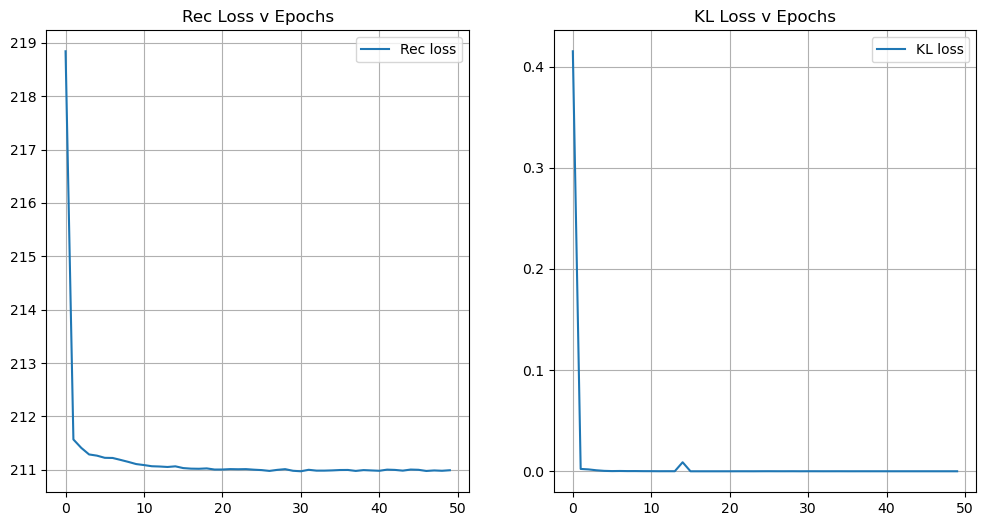

In [54]:
fig, axs = plt.subplots(figsize=(12,6), nrows=1, ncols=2)

axs[0].set_title(f"Rec Loss v Epochs")
axs[0].plot(rec_losses, label="Rec loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title(f"KL Loss v Epochs")
axs[1].plot(kl_losses, label="KL loss")
axs[1].legend()
axs[1].grid()

### Sampling some images

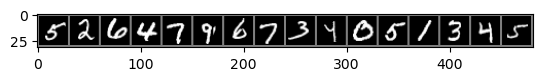

In [55]:
# get original images

N_SAMPLES = 16

real, label = next(iter(train_loader))

real = real[:N_SAMPLES]
pil_img = imshow(torchvision.utils.make_grid(real.to(device),nrow=16))

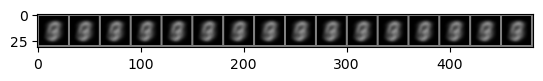

In [56]:
mus, logvars = mnist_vae.encoder(real)
samples = mnist_vae.decoder(mus)

pil_samples_img = imshow(torchvision.utils.make_grid(samples.to(device),nrow=16))

### Changing pipeline to use Binary Cross Entropy as a loss instead of L2

In [57]:
# here, we normalize between 0 and 1
batch_size=128 # can go to 4096+ for RTX 3080

# file path, depends where we run
datapath = '/home/benjamin.deporte/MVA/TP_GenAI_MVA_2025_02_25/data'  # setup IRT
# datapath = '/home/benjamin/Folders_Python/TP_GenAI_MVA_2025_02_25/data'  # setup CPU local

# MNIST Dataset
train_dataset2 = MNIST(datapath, train=True, transform=transforms.ToTensor(), download=True)
test_dataset2 = MNIST(datapath, train=False, transform=transforms.ToTensor(), download=False)

# Data Loader for FULL dataset 
train_loader2 = torch.utils.data.DataLoader(dataset=train_dataset2, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader2 = torch.utils.data.DataLoader(dataset=test_dataset2, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

# Small dataloader to test the pipeline
N_SMALL = 1000
subset_indices = range(N_SMALL)
subset = Subset(train_dataset2, subset_indices)

sample_loader = data.DataLoader(subset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

torch.Size([128, 1, 28, 28])
Min = 0.0
Max = 0.996078431372549


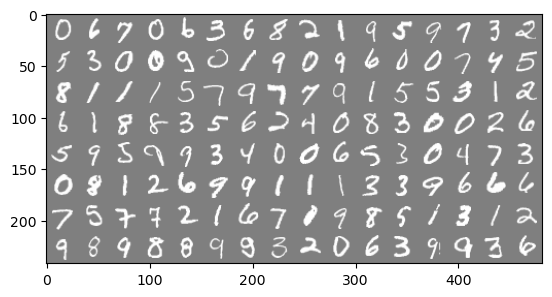

In [58]:
real,_ = next(iter(train_loader2))
print(real.shape)

pil_img = imshow(torchvision.utils.make_grid(real.to('cpu'),nrow=16))

print(f"Min = {real[0].min()}")
print(f"Max = {real[0].max()}")

### Starting simple : encoder and decoder are MLPs

In [59]:
class EncoderMLP2(nn.Module):
        def __init__(self, latent_dim=latent_dim, n_neurons=512):
                super(EncoderMLP2, self).__init__()
                
                self.fc1 = nn.Linear(1*28*28, n_neurons)
                self.fc2 = nn.Linear(n_neurons, n_neurons)
                # self.fc3 = nn.Linear(n_neurons, n_neurons)
                self.fc_mu = nn.Linear(n_neurons, latent_dim)
                self.fc_logvar = nn.Linear(n_neurons, latent_dim)
                                
        def forward(self,inputs):
                # input is B x 1 x 28 x 28
                x = inputs.view(-1, 784)             
                x = F.relu(self.fc1(x)) 
                x = F.relu(self.fc2(x)) 
                mu_x = self.fc_mu(x) # out : B x latent_dim
                logvar_x = self.fc_logvar(x) # out : B x latent_dim

                return mu_x, logvar_x

In [60]:
# # checking dimensions...
# # 
# encoder = EncoderMLP2()

# batch_example_size = 8

# x = torch.randn((batch_example_size,1,28,28))
# print(f"input = {x.shape}")

# mu, logvar = encoder(x.view(-1,784))
# print(f"output mu = {mu.shape}")
# print(f"output logvar = {logvar.shape}")

In [61]:
# Decoder to sample back from vector latent_dim to 28 x 28 within [0,1]^784

class DecoderMLP2(nn.Module):
        def __init__(self, latent_dim=latent_dim, n_neurons=256):
                super(DecoderMLP2, self).__init__()

                # self.fc1 = nn.Linear(latent_dim, n_neurons)
                # self.fc2 = nn.Linear(n_neurons, n_neurons)
                # self.fc3 = nn.Linear(n_neurons, 1*28*28)
                
                self.fc4 = nn.Linear(latent_dim, 256)
                self.fc5 = nn.Linear(256, 512)
                self.fc6 = nn.Linear(512, 784)
                
        def forward(self, inputs):
                x = F.relu(self.fc4(inputs))
                x = F.relu(self.fc5(x))
                x = F.sigmoid(self.fc6(x))
                
                return x

In [62]:
# # check dimensions
# decoder = DecoderMLP2()
# x = torch.randn(8, latent_dim) # B (batch size) x latent_dim
# print(f"input shape = {x.shape}")
# out = decoder(x)
# print(f"output shape = {out.shape}")

# print(out.min())
# print(out.max())

In [63]:
class MnistVAE2(nn.Module):
    
    def __init__(self, n_neurons=256, latent_dim=2): #, scale=1.0):
        super(MnistVAE2, self).__init__()
        
        self.encoder = EncoderMLP2(latent_dim=latent_dim)
        self.decoder = DecoderMLP2(latent_dim=latent_dim)
        
    def rsample(self, mean, std):
        # mean : B x latent_dim
        # std : B x latent_dim
        epsilon = torch.randn_like(mean) # N(0,1) shape B x latent_dim 
        z = mean + std * epsilon # * scale # B x 1 \sim \mathcal{N}(mu, var)
        return z
    
    def forward(self,inputs):
        
        # encoder forward
        mu_x, logvar_x = self.encoder(x)
        
        # sample with reparametrisation trick
        std_x = torch.exp(0.5 * logvar_x)
        z = self.rsample(mu_x, std_x)
        
        # decoder forward
        x_hat = self.decoder(z)
        
        return x_hat, mu_x, logvar_x

In [64]:
# # check dimensions
# mvae = MnistVAE2(latent_dim=latent_dim)

# x = torch.randn(128, 1, 28, 28) # B (batch size) x 1 x 28 x 28

# print(f"input shape = {x.shape}")

# x_hat, mu, logvar = mvae(x)

# print(f"outputs shapes : x_hat = {x_hat.size()}, mus = {mu.size()},  logvars = {logvar.size()}")

# print(x_hat.min())
# print(x_hat.max())

# must be :
# input shape = torch.Size([128, 1, 28, 28])
# outputs shapes : x_hat = torch.Size([128, 784]), mus = torch.Size([128, 2]),  logvars = torch.Size([128, 2])


In [65]:
def mnist_vae_bceloss(x, x_hat, mean, logvar): #, kl_weight=0.5):
    
    reconstruction_loss = F.binary_cross_entropy(x, x_hat, reduction='mean')
    kl_loss = - 0.5 * torch.sum( 1 + logvar - mean**2 - logvar.exp())

    return reconstruction_loss + kl_loss, kl_loss, reconstruction_loss # + kl_loss

In [66]:
# x = next(iter(train_loader2))[0]

# x_hat, mu, logvar = mvae(x.view(-1,784))
# print(x.size())
# print(x_hat.size())
# print(x_hat.min())
# print(x_hat.max())
# mnist_vae_bceloss(x, x_hat, mu, logvar)

In [67]:
def train_MNIST_VAE_BCE(
    loader = None,
    n_epochs = 50,
    optimizer = None,
    model = None,
    kl_weight = 0.5
):
    """_summary_

    Args:
        loader (_type_, optional): sample_loader ou train_loader. Defaults to None.
        n_epochs (int, optional): _description_. Defaults to 50.
        optimizer (_type_, optional): 
        kl_weight : weight of the KL in the total loss, should not be changed. Default to 0.5
        
    Returns:
        _type_: lists of losses
    """
    
    print(f"Start training {n_epochs} epochs on MNIST VAE")
    rec_losses = []
    kl_losses = []
    total_losses = []
       
    for epoch in range(n_epochs):
        
        # init batch measurements
        batch_kl_losses = []
        batch_rec_losses = []
        batch_total_losses = []
        
        for i, batch in enumerate(loader, 0):
            
            # forward pass
            x = batch[0].view(-1,784)
            x_hat, mean, logvar = model(x)
            
            # backward pass
            optimizer.zero_grad()
            total_loss, kl_loss, rec_loss = mnist_vae_bceloss(x_hat, x, mean, logvar) # Nasty bug : x_hat and x not interchangeable...
            total_loss.backward()
            optimizer.step()
            
            # logging at batch level
            batch_kl_losses.append(kl_loss.item())
            batch_rec_losses.append(rec_loss.item())
            batch_total_losses.append(total_loss.item())
            
            # reporting out at batch level
            print(f"Batch {i+1} / {len(loader)} \
            -- total loss = {batch_total_losses[-1]:.4f} \
            # -- reco loss = {batch_rec_losses[-1]:.4f} \
            # -- KL loss = {batch_kl_losses[-1]:.4f}", \
            end="\r")
            
        # logging at epoch level
        total_losses.append(np.average(batch_total_losses))  
        rec_losses.append(np.average(batch_rec_losses)) 
        kl_losses.append(np.average(batch_kl_losses)) 
        
        # reporting out at epoch level
        print(f"Epoch {epoch+1} / {n_epochs} \
            -- loss = {total_losses[-1]:.4f} \
            # -- rec_loss = {rec_losses[-1]:.4f} \
            # -- kl_loss = {kl_losses[-1]:.4f} \
                                           ")
        
    return total_losses, rec_losses, kl_losses  

In [68]:
latent_dim = 16
mvae = MnistVAE2(latent_dim=latent_dim)

lr = 1e-4
optimizer_mvae = torch.optim.Adam(mvae.parameters(), lr=lr)

In [69]:
n_epochs = 1000

total_losses, rec_losses, kl_losses = train_MNIST_VAE_BCE(
    loader=sample_loader, 
    n_epochs=n_epochs, 
    optimizer=optimizer_mvae, 
    model=mvae,
    )

Start training 1000 epochs on MNIST VAE
Epoch 1 / 1000             -- loss = 9.1151             # -- rec_loss = 0.6892             # -- kl_loss = 8.4259                                            
Epoch 2 / 1000             -- loss = 3.0476             # -- rec_loss = 0.6722             # -- kl_loss = 2.3754                                            
Epoch 3 / 1000             -- loss = 1.4418             # -- rec_loss = 0.6516             # -- kl_loss = 0.7902                                            
Epoch 4 / 1000             -- loss = 0.9720             # -- rec_loss = 0.6243             # -- kl_loss = 0.3477                                            
Epoch 5 / 1000             -- loss = 0.7643             # -- rec_loss = 0.5891             # -- kl_loss = 0.1752                                            
Epoch 6 / 1000             -- loss = 0.6201             # -- rec_loss = 0.5475             # -- kl_loss = 0.0725                                            
Epoch 7 / 1000    

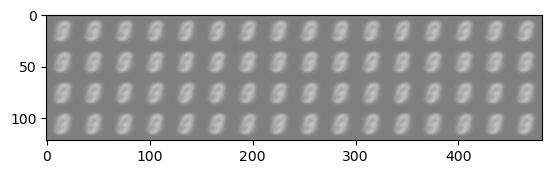

In [70]:
with torch.no_grad():
    z = torch.randn(64, latent_dim)
    sample = mvae.decoder(z)

s = sample.view(64,1,28,28)

pil_img = imshow(torchvision.utils.make_grid(s.to('cpu'),nrow=16))

### Next : encoder and decoder are Conv2D-based

In [71]:
class MnistVAE_CNN(nn.Module):
    
    def __init__(self, latent_dim=2): #, scale=1.0):
        super(MnistVAE_CNN, self).__init__()
        
        self.encoder = Encoder2D(latent_dim=latent_dim)
        self.decoder = Decoder2D(latent_dim=latent_dim)
        
    def rsample(self, mean, std):
        # mean : B x latent_dim
        # std : B x latent_dim
        epsilon = torch.randn_like(mean) # N(0,1) shape B x latent_dim 
        z = mean + std * epsilon # * scale # B x 1 \sim \mathcal{N}(mu, var)
        return z
    
    def forward(self,inputs):
        
        # encoder forward
        mu_x, logvar_x = self.encoder(x)
        
        # sample with reparametrisation trick
        std_x = torch.exp(0.5 * logvar_x)
        z = self.rsample(mu_x, std_x)
        
        # decoder forward
        x_hat = F.sigmoid(self.decoder(z)).view(-1,784)
        
        return x_hat, mu_x, logvar_x

In [72]:
# # check dimensions
# mvae = MnistVAE_CNN(latent_dim=latent_dim)

# x = torch.randn(128, 1, 28, 28) # B (batch size) x 1 x 28 x 28

# print(f"input shape = {x.shape}")

# x_hat, mu, logvar = mvae(x)

# print(f"outputs shapes : x_hat = {x_hat.size()}, mus = {mu.size()},  logvars = {logvar.size()}")

# print(x_hat.min())
# print(x_hat.max())

# MUST BE :
# input shape = torch.Size([128, 1, 28, 28])
# outputs shapes : x_hat = torch.Size([128, 784]), mus = torch.Size([128, 2]),  logvars = torch.Size([128, 2])

In [73]:
latent_dim = 16
mvae = MnistVAE_CNN(latent_dim=latent_dim)

lr = 1e-4
optimizer_mvae = torch.optim.Adam(mvae.parameters(), lr=lr)

In [74]:
n_epochs = 100

total_losses, rec_losses, kl_losses = train_MNIST_VAE_BCE(
    loader=train_loader2, 
    n_epochs=n_epochs, 
    optimizer=optimizer_mvae, 
    model=mvae,
    )

Start training 100 epochs on MNIST VAE
Epoch 1 / 100             -- loss = 0.4417             # -- rec_loss = 0.3801             # -- kl_loss = 0.0616                                            
Epoch 2 / 100             -- loss = 0.2729             # -- rec_loss = 0.2723             # -- kl_loss = 0.0006                                            
Epoch 3 / 100             -- loss = 0.2692             # -- rec_loss = 0.2689             # -- kl_loss = 0.0003                                            
Epoch 4 / 100             -- loss = 0.2675             # -- rec_loss = 0.2674             # -- kl_loss = 0.0002                                            
Epoch 5 / 100             -- loss = 0.2665             # -- rec_loss = 0.2664             # -- kl_loss = 0.0001                                            
Epoch 6 / 100             -- loss = 0.2660             # -- rec_loss = 0.2659             # -- kl_loss = 0.0001                                            
Epoch 7 / 100            

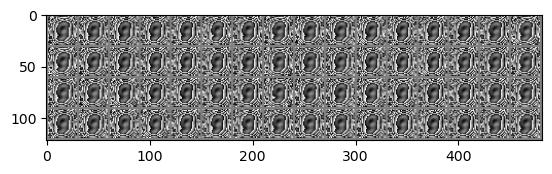

In [75]:
with torch.no_grad():
    z = torch.randn(64, latent_dim)
    sample = mvae.decoder(z)

s = sample.view(64,1,28,28)

pil_img = imshow(torchvision.utils.make_grid(s.to('cpu'),nrow=16))

### Q3.a

Not enough time to fine-tune the paramters and have the models actually generate images

### Q3.b

Definitely VAE. It is actually easier to train.

### Frechet Inception Distance